# Main BERTopic pipeline with hyperparameters tuning for United Document Approach (UNI)

## Preparation

In [1]:
# Import libraries
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm
from bertopic import BERTopic

C:\Users\NMT\anaconda3\envs\Python39\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\NMT\anaconda3\envs\Python39\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\NMT\anaconda3\envs\Python39\lib\site-packages\umap\distances.py:1086: NumbaDepr

Read raw csv file of data with CWE described by attributes in text

In [2]:
# Specify the file path
#file_path_input = '../Input/simulated_data_AllSoftware.csv'
#file_path_input = '../Input/simulated_data_AllHardware.csv'
file_path_input = '../Input/simulated_data_AllSoftwareHardware.csv'

# Open the file
with open(file_path_input, mode='r', encoding='utf-8') as file:
    # Create a CSV reader
    csv_reader = csv.reader(file)
    
    # Read the headers (first row) into a list
    #headers = next(csv_reader)
    
    # Create a list to store the data
    raw_data = []
    
    # Loop through each row in the CSV file
    for row in csv_reader:
        # Append the row data as a list to the data list
        raw_data.append(row)

Join all attributes(features) into one clear text

In [3]:
# Initialize empty list to store the text data and cwe id list
docs = []
cwe_list = []
feature_data = []

for row in raw_data:
    tmplst = [row[i] for i in range(1,len(row))]
    docs.append(" ".join(tmplst))
    feature_data.append(tmplst)
    cwe_list.append(str(row[0]))

Prepare BERT Sentence Embeddings (skip this section if a saved embedding file to be loaded)

In [4]:
# Choose the approach to deal with the raw data
#approach = "raw"
approach = "whole_doc"

if approach == "raw":
    data = feature_data # Each attribute is encoded separately
elif approach == "whole_doc":
    data = docs # Attibutes are combined into one text doc to be encoded

In [5]:
# Choose the sentence embedder
sentence_embedder = "SBERT"

In [6]:
if sentence_embedder == "SBERT":
    from sentence_transformers import SentenceTransformer

    #sentence_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

In [7]:
# For UNI approach
# Initialize empty list to store the text embedding
data_lst = []

# For loop to Encode each CWE text as embeddings (= long numerical vector)
for e, row in enumerate(tqdm(data)):
    embeddings = sentence_model.encode(row, show_progress_bar=False).reshape(1, -1)
    data_lst.append(embeddings)

text_embeddings = np.vstack(data_lst)
print(text_embeddings.shape)

100%|██████████| 503/503 [00:06<00:00, 83.64it/s] 

(503, 384)


In [8]:
# Optional save the text embeddings as csv file to be reused
embed_filepathname = f"Embeddings/{sentence_embedder}_{approach}.csv"
np.savetxt(embed_filepathname, text_embeddings, delimiter = ",")

(Optional) Load the saved text embeddings

In [4]:
# Reused the previously saved embeddings so the embedding process can be skipped
embed_filepathname = "Embeddings/SBERT_whole_doc.csv"
text_embeddings = np.genfromtxt(embed_filepathname, delimiter=',')

In [5]:
text_embeddings.shape

(503, 384)

Functions for options of Dimension Reduction methods

In [6]:
from umap import UMAP

def get_umap(n_components, n_neighbors=15, min_dist=0.0, metric='cosine', random_state=42, verbose=True):
    my_umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, 
                   random_state=random_state, verbose=verbose)
    return my_umap

In [7]:
from sklearn.decomposition import PCA

def get_pca(n_components=None):
    my_pca = PCA(n_components=n_components, random_state=0)
    return my_pca

Functions for options of main Clustering algorithms

In [8]:
from hdbscan import HDBSCAN

def get_hdbscan(min_cluster_size=2, min_samples=None, metric='euclidean', cluster_selection_method='eom', prediction_data=True):
    my_hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric, 
                         cluster_selection_method=cluster_selection_method, prediction_data=prediction_data)
    return my_hdbscan

In [9]:
from sklearn.cluster import KMeans

def get_kmeans(n_clusters, random_state=0):
    my_kmeans = KMeans(n_clusters, n_init="auto", random_state=random_state)
    return my_kmeans

In [10]:
from sklearn.cluster import AgglomerativeClustering

def get_aggloClus(distance_threshold=0, n_clusters=None):
    my_model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters)
    return my_model

Functions for Topic Representation

In [11]:
# Create a customised stop-word list
from sklearn.feature_extraction import text

# the query words list for attribute headers
query_words = ["cwe", "vulnerability", "vulnerabilities", "method", "methods", "technical", "impact", "security", "property", "properties", "severity", "likelihood", "relevant", "asset", "assets", "attack", "vector", "attacker", "type", "motive", "cyber", "controls", "countermeasure", "countermeasures", "detection"]

# The original stop words list in Scikit-learn
stop_words_ori = text.ENGLISH_STOP_WORDS
stop_words = stop_words_ori.union(query_words)

# Combine with list of CWE id
stop_words = stop_words.union(cwe_list)

stop_words_cust = list(stop_words)

In [12]:
# Control the length of topic terms (default = 1-2 words) and stop-words list
from sklearn.feature_extraction.text import CountVectorizer

def get_Vectorizer(ngram_range=(1, 2), stop_words=stop_words_cust): 
    my_Vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words)
    return my_Vectorizer

## Main Run

Libraries for Main run

In [13]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

### Main BERTopic tuning run (UMAP + HDBSCAN)

In [14]:
# Set up Range of n_components (UMAP parameter)
n_components_rng = range(5, 85, 5)
# Set up Range of n_neighbors (UMAP parameter)
n_neighbors_rng = range(5, 35, 5)

# Initialize a list of lists for results with headers
results = [["n_neighbors", "n_components", "total_clusters", "total_outliers", "min_cluster_size", "max_cluster_size", "avg_cluster_size", "sil_ex", "sil_in", "cal_ex", 
            "cal_in", "div_score", "c_v_score", "u_mass_score", "uci_score", "npmi_score"]]

# Loop for all possible combinations of n_components and n_neighbors
for neighbor in tqdm(n_neighbors_rng):
    for component in tqdm(n_components_rng):

        topic_model = BERTopic(
        
            # Pipeline models
            embedding_model=None,
            umap_model=get_umap(n_components=component, n_neighbors=neighbor), # Dimension Reduction method
            hdbscan_model=get_hdbscan(min_cluster_size=2, min_samples=None), # main Clustering algorithm
            vectorizer_model=get_Vectorizer(ngram_range=(1, 2), stop_words=stop_words_cust), # Topic Representation
            representation_model=None,
        
            # Hyperparameters
            top_n_words=20, # the top n topic words/terms to show
            verbose = False
        )
        
        # Train model
        topics, probs = topic_model.fit_transform(docs, text_embeddings)

        # Retrieve meta data
        counter = topic_model.topic_sizes_.copy() # sizes of each topic/cluster
        total_clusters = max(topics) + 1 # number of topics/clusters ex. outliers
        try:
            total_outliers = counter.pop(-1)
        except:
            total_outliers = 0
        min_cluster_size = min(counter.values())
        max_cluster_size = max(counter.values())
        avg_cluster_size = sum(counter.values())/total_clusters

        # Extract the Text Embeddingsand Labels for exclude/include outliers
        # ex. outliers
        indices = [index for index, topic in enumerate(topics) if topic != -1]
        X = text_embeddings[np.array(indices)]
        labels = [topic for index, topic in enumerate(topics) if topic != -1]
        
        # in. outliers
        indices_ = [index for index, topic in enumerate(topics)]
        X_ = text_embeddings[np.array(indices_)]
        labels_ = [topic for index, topic in enumerate(topics)]
        
        # Calculate silhouette and CH score
        sil_ex = silhouette_score(X, labels)
        ch_ex = calinski_harabasz_score(X, labels)
        sil_in = silhouette_score(X_, labels_)
        ch_in = calinski_harabasz_score(X_, labels_)

        # Compute Topic Diversity score by OCTIS
        bertopic_topics = [[vals[0] for vals in topic_model.get_topic(i)[:10]] for i in range(len(set(topics)) - 1)]
        output_tm = {"topics": bertopic_topics}
        topic_diversity = TopicDiversity(topk=10)
        div_score = topic_diversity.score(output_tm)
        
        # For Computing Topic Coherence Scores (cv, umass, uci, npmi)
        # Extract vectorizer and analyzer from BERTopic
        vectorizer = topic_model.vectorizer_model
        analyzer = vectorizer.build_analyzer()
        
        # Extract features for Topic Coherence evaluation
        words = vectorizer.get_feature_names_out()
        tokens = [analyzer(doc) for doc in docs]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]
        topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                       for topic in range(len(set(topics))-1)]
        
        # Compute Topic Coherence Scores by Gensim
        c_v = CoherenceModel(topics=topic_words, topn=10,
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='c_v')
        u_mass = CoherenceModel(topics=topic_words, topn=10,
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='u_mass')
        uci = CoherenceModel(topics=topic_words, topn=10,
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='c_uci')
        npmi = CoherenceModel(topics=topic_words, topn=10,
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='c_npmi')
        c_v_score = c_v.get_coherence()
        u_mass_score = u_mass.get_coherence()
        uci_score = uci.get_coherence()
        npmi_score = npmi.get_coherence()
        
        # save the results of 1 combination of n_neighbor, n_component
        result = [neighbor, component, total_clusters, total_outliers, min_cluster_size, max_cluster_size, avg_cluster_size, 
                  sil_ex, sil_in, ch_ex, ch_in, div_score, c_v_score, u_mass_score, uci_score, npmi_score]
        results.append(result)

  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 00:56:33 2023 Construct fuzzy simplicial set
Tue Aug  1 00:56:33 2023 Finding Nearest Neighbors
Tue Aug  1 00:56:35 2023 Finished Nearest Neighbor Search
Tue Aug  1 00:56:37 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  27%| ██▋        137/500 [00:00]

Epochs completed:  54%| █████▍     269/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 00:56:39 2023 Finished embedding



  6%|▋         | 1/16 [01:00<15:04, 60.28s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 00:57:33 2023 Construct fuzzy simplicial set
Tue Aug  1 00:57:33 2023 Finding Nearest Neighbors
Tue Aug  1 00:57:33 2023 Finished Nearest Neighbor Search
Tue Aug  1 00:57:33 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  24%| ██▍        121/500 [00:00]

Epochs completed:  46%| ████▋      232/500 [00:00]

Epochs completed:  71%| ███████    355/500 [00:00]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 00:57:34 2023 Finished embedding



 12%|█▎        | 2/16 [01:48<12:24, 53.20s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 00:58:21 2023 Construct fuzzy simplicial set
Tue Aug  1 00:58:22 2023 Finding Nearest Neighbors
Tue Aug  1 00:58:22 2023 Finished Nearest Neighbor Search
Tue Aug  1 00:58:22 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  21%| ██         103/500 [00:00]

Epochs completed:  40%| ████       202/500 [00:01]

Epochs completed:  61%| ██████     303/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 00:58:23 2023 Finished embedding



 19%|█▉        | 3/16 [02:39<11:17, 52.14s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 00:59:12 2023 Construct fuzzy simplicial set
Tue Aug  1 00:59:12 2023 Finding Nearest Neighbors
Tue Aug  1 00:59:12 2023 Finished Nearest Neighbor Search
Tue Aug  1 00:59:12 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  16%| █▌         78/500 [00:00]

Epochs completed:  34%| ███▎       168/500 [00:00]

Epochs completed:  53%| █████▎     264/500 [00:00]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 00:59:14 2023 Finished embedding



 25%|██▌       | 4/16 [03:28<10:13, 51.11s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:00:02 2023 Construct fuzzy simplicial set
Tue Aug  1 01:00:02 2023 Finding Nearest Neighbors
Tue Aug  1 01:00:02 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:00:02 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  19%| █▊         93/500 [00:00]

Epochs completed:  37%| ███▋       184/500 [00:01]

Epochs completed:  55%| █████▍     274/500 [00:01]

Epochs completed:  73%| ███████▎   366/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:00:03 2023 Finished embedding



 31%|███▏      | 5/16 [04:17<09:12, 50.19s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:00:50 2023 Construct fuzzy simplicial set
Tue Aug  1 01:00:51 2023 Finding Nearest Neighbors
Tue Aug  1 01:00:51 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:00:51 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  16%| █▌         78/500 [00:00]

Epochs completed:  31%| ███        154/500 [00:00]

Epochs completed:  46%| ████▌      231/500 [00:00]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  77%| ███████▋   383/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:00:52 2023 Finished embedding



 38%|███▊      | 6/16 [05:06<08:18, 49.86s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:01:40 2023 Construct fuzzy simplicial set
Tue Aug  1 01:01:40 2023 Finding Nearest Neighbors
Tue Aug  1 01:01:40 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:01:40 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  17%| █▋         86/500 [00:00]

Epochs completed:  36%| ███▌       180/500 [00:01]

Epochs completed:  55%| █████▌     277/500 [00:01]

Epochs completed:  75%| ███████▍   374/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:01:41 2023 Finished embedding



 44%|████▍     | 7/16 [05:53<07:19, 48.84s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:02:26 2023 Construct fuzzy simplicial set
Tue Aug  1 01:02:26 2023 Finding Nearest Neighbors
Tue Aug  1 01:02:26 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:02:26 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  19%| █▊         93/500 [00:00]

Epochs completed:  37%| ███▋       184/500 [00:00]

Epochs completed:  55%| █████▍     273/500 [00:00]

Epochs completed:  73%| ███████▎   363/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:02:28 2023 Finished embedding



 50%|█████     | 8/16 [06:40<06:26, 48.34s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:03:14 2023 Construct fuzzy simplicial set
Tue Aug  1 01:03:14 2023 Finding Nearest Neighbors
Tue Aug  1 01:03:14 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:03:14 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  16%| █▌         78/500 [00:00]

Epochs completed:  30%| ███        152/500 [00:00]

Epochs completed:  46%| ████▌      230/500 [00:00]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  77%| ███████▋   384/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:03:15 2023 Finished embedding



 56%|█████▋    | 9/16 [07:28<05:36, 48.03s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:04:01 2023 Construct fuzzy simplicial set
Tue Aug  1 01:04:01 2023 Finding Nearest Neighbors
Tue Aug  1 01:04:01 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:04:01 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▌         75/500 [00:00]

Epochs completed:  30%| ██▉        148/500 [00:00]

Epochs completed:  44%| ████▍      222/500 [00:00]

Epochs completed:  58%| █████▊     289/500 [00:01]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:04:02 2023 Finished embedding



 62%|██████▎   | 10/16 [08:15<04:47, 47.92s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:04:49 2023 Construct fuzzy simplicial set
Tue Aug  1 01:04:49 2023 Finding Nearest Neighbors
Tue Aug  1 01:04:49 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:04:49 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         69/500 [00:00]

Epochs completed:  27%| ██▋        135/500 [00:00]

Epochs completed:  41%| ████       203/500 [00:00]

Epochs completed:  54%| █████▍     270/500 [00:01]

Epochs completed:  67%| ██████▋    337/500 [00:01]

Epochs completed:  81%| ████████   403/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:04:50 2023 Finished embedding



 69%|██████▉   | 11/16 [09:05<04:02, 48.48s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:05:38 2023 Construct fuzzy simplicial set
Tue Aug  1 01:05:39 2023 Finding Nearest Neighbors
Tue Aug  1 01:05:39 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:05:39 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         66/500 [00:00]

Epochs completed:  26%| ██▌        128/500 [00:00]

Epochs completed:  38%| ███▊       191/500 [00:00]

Epochs completed:  51%| █████      254/500 [00:01]

Epochs completed:  64%| ██████▎    318/500 [00:01]

Epochs completed:  76%| ███████▌   378/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:05:40 2023 Finished embedding



 75%|███████▌  | 12/16 [09:53<03:12, 48.24s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:06:26 2023 Construct fuzzy simplicial set
Tue Aug  1 01:06:26 2023 Finding Nearest Neighbors
Tue Aug  1 01:06:26 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:06:26 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  17%| █▋         86/500 [00:00]

Epochs completed:  34%| ███▍       169/500 [00:00]

Epochs completed:  51%| █████      253/500 [00:00]

Epochs completed:  67%| ██████▋    337/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:06:28 2023 Finished embedding



 81%|████████▏ | 13/16 [10:40<02:24, 48.11s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:07:14 2023 Construct fuzzy simplicial set
Tue Aug  1 01:07:14 2023 Finding Nearest Neighbors
Tue Aug  1 01:07:14 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:07:14 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▍         73/500 [00:00]

Epochs completed:  29%| ██▉        146/500 [00:00]

Epochs completed:  40%| ████       202/500 [00:00]

Epochs completed:  54%| █████▍     271/500 [00:01]

Epochs completed:  68%| ██████▊    338/500 [00:01]

Epochs completed:  82%| ████████▏  409/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:07:15 2023 Finished embedding



 88%|████████▊ | 14/16 [11:28<01:35, 48.00s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:08:02 2023 Construct fuzzy simplicial set
Tue Aug  1 01:08:02 2023 Finding Nearest Neighbors
Tue Aug  1 01:08:02 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:08:02 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▍         73/500 [00:00]

Epochs completed:  28%| ██▊        141/500 [00:00]

Epochs completed:  42%| ████▏      212/500 [00:00]

Epochs completed:  57%| █████▋     283/500 [00:01]

Epochs completed:  71%| ███████    354/500 [00:01]

Epochs completed:  85%| ████████▌  426/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:08:03 2023 Finished embedding



 94%|█████████▍| 15/16 [12:18<00:48, 48.39s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=5, random_state=42, verbose=True)
Tue Aug  1 01:08:51 2023 Construct fuzzy simplicial set
Tue Aug  1 01:08:51 2023 Finding Nearest Neighbors
Tue Aug  1 01:08:51 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:08:51 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         69/500 [00:00]

Epochs completed:  27%| ██▋        135/500 [00:00]

Epochs completed:  41%| ████       203/500 [00:00]

Epochs completed:  54%| █████▍     270/500 [00:01]

Epochs completed:  68%| ██████▊    338/500 [00:01]

Epochs completed:  81%| ████████   405/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:08:53 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:09:39 2023 Construct fuzzy simplicial set
Tue Aug  1 01:09:39 2023 Finding Nearest Neighbors
Tue Aug  1 01:09:39 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:09:39 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  18%| █▊         92/500 [00:00]

Epochs completed:  37%| ███▋       185/500 [00:00]

Epochs completed:  55%| █████▌     277/500 [00:00]

Epochs completed:  74%| ███████▎   368/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:09:41 2023 Finished embedding



  6%|▋         | 1/16 [00:46<11:44, 46.95s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:10:26 2023 Construct fuzzy simplicial set
Tue Aug  1 01:10:26 2023 Finding Nearest Neighbors
Tue Aug  1 01:10:26 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:10:26 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  17%| █▋         84/500 [00:00]

Epochs completed:  33%| ███▎       164/500 [00:00]

Epochs completed:  49%| ████▉      246/500 [00:01]

Epochs completed:  65%| ██████▌    326/500 [00:01]

Epochs completed:  81%| ████████▏  407/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:10:28 2023 Finished embedding



 12%|█▎        | 2/16 [01:34<10:59, 47.10s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:11:13 2023 Construct fuzzy simplicial set
Tue Aug  1 01:11:14 2023 Finding Nearest Neighbors
Tue Aug  1 01:11:14 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:11:14 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▍         74/500 [00:00]

Epochs completed:  29%| ██▉        144/500 [00:00]

Epochs completed:  43%| ████▎      215/500 [00:00]

Epochs completed:  57%| █████▋     286/500 [00:01]

Epochs completed:  71%| ███████    356/500 [00:01]

Epochs completed:  86%| ████████▌  428/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:11:15 2023 Finished embedding



 19%|█▉        | 3/16 [02:21<10:11, 47.07s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:12:00 2023 Construct fuzzy simplicial set
Tue Aug  1 01:12:01 2023 Finding Nearest Neighbors
Tue Aug  1 01:12:01 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:12:01 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         69/500 [00:00]

Epochs completed:  27%| ██▋        136/500 [00:00]

Epochs completed:  41%| ████       203/500 [00:00]

Epochs completed:  54%| █████▎     268/500 [00:01]

Epochs completed:  67%| ██████▋    335/500 [00:01]

Epochs completed:  80%| ████████   401/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:12:02 2023 Finished embedding



 25%|██▌       | 4/16 [03:09<09:28, 47.41s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:12:48 2023 Construct fuzzy simplicial set
Tue Aug  1 01:12:49 2023 Finding Nearest Neighbors
Tue Aug  1 01:12:49 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:12:49 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         63/500 [00:00]

Epochs completed:  25%| ██▌        125/500 [00:00]

Epochs completed:  37%| ███▋       186/500 [00:00]

Epochs completed:  49%| ████▉      245/500 [00:01]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  74%| ███████▎   368/500 [00:01]

Epochs completed:  85%| ████████▌  427/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:12:50 2023 Finished embedding



 31%|███▏      | 5/16 [03:56<08:39, 47.24s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:13:35 2023 Construct fuzzy simplicial set
Tue Aug  1 01:13:35 2023 Finding Nearest Neighbors
Tue Aug  1 01:13:35 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:13:35 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          51/500 [00:00]

Epochs completed:  20%| ██         102/500 [00:00]

Epochs completed:  30%| ███        152/500 [00:00]

Epochs completed:  40%| ████       202/500 [00:01]

Epochs completed:  51%| █████      253/500 [00:01]

Epochs completed:  61%| ██████     305/500 [00:01]

Epochs completed:  71%| ███████▏   357/500 [00:01]

Epochs completed:  81%| ████████▏  407/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:13:37 2023 Finished embedding



 38%|███▊      | 6/16 [04:48<08:08, 48.89s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:14:27 2023 Construct fuzzy simplicial set
Tue Aug  1 01:14:28 2023 Finding Nearest Neighbors
Tue Aug  1 01:14:28 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:14:28 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         66/500 [00:00]

Epochs completed:  26%| ██▌        130/500 [00:00]

Epochs completed:  39%| ███▉       196/500 [00:00]

Epochs completed:  52%| █████▏     261/500 [00:01]

Epochs completed:  65%| ██████▌    326/500 [00:01]

Epochs completed:  78%| ███████▊   391/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:14:29 2023 Finished embedding



 44%|████▍     | 7/16 [05:35<07:16, 48.54s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:15:15 2023 Construct fuzzy simplicial set
Tue Aug  1 01:15:15 2023 Finding Nearest Neighbors
Tue Aug  1 01:15:15 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:15:15 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         62/500 [00:00]

Epochs completed:  25%| ██▍        123/500 [00:01]

Epochs completed:  37%| ███▋       184/500 [00:01]

Epochs completed:  49%| ████▉      244/500 [00:01]

Epochs completed:  61%| ██████     304/500 [00:01]

Epochs completed:  73%| ███████▎   364/500 [00:01]

Epochs completed:  85%| ████████▍  424/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:15:17 2023 Finished embedding



 50%|█████     | 8/16 [06:25<06:31, 48.92s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:16:05 2023 Construct fuzzy simplicial set
Tue Aug  1 01:16:05 2023 Finding Nearest Neighbors
Tue Aug  1 01:16:05 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:16:05 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          50/500 [00:00]

Epochs completed:  19%| █▉         97/500 [00:00]

Epochs completed:  30%| ██▉        149/500 [00:01]

Epochs completed:  40%| ███▉       198/500 [00:01]

Epochs completed:  50%| ████▉      249/500 [00:01]

Epochs completed:  60%| █████▉     299/500 [00:01]

Epochs completed:  69%| ██████▉    347/500 [00:01]

Epochs completed:  79%| ███████▉   395/500 [00:01]

Epochs completed:  89%| ████████▉  444/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:16:07 2023 Finished embedding



 56%|█████▋    | 9/16 [07:12<05:38, 48.35s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:16:52 2023 Construct fuzzy simplicial set
Tue Aug  1 01:16:52 2023 Finding Nearest Neighbors
Tue Aug  1 01:16:52 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:16:52 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          51/500 [00:00]

Epochs completed:  20%| █▉         99/500 [00:00]

Epochs completed:  30%| ██▉        148/500 [00:00]

Epochs completed:  39%| ███▉       197/500 [00:01]

Epochs completed:  49%| ████▉      246/500 [00:01]

Epochs completed:  59%| █████▉     296/500 [00:01]

Epochs completed:  69%| ██████▉    346/500 [00:01]

Epochs completed:  79%| ███████▉   396/500 [00:01]

Epochs completed:  89%| ████████▉  445/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:16:54 2023 Finished embedding



 62%|██████▎   | 10/16 [08:01<04:50, 48.43s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:17:41 2023 Construct fuzzy simplicial set
Tue Aug  1 01:17:41 2023 Finding Nearest Neighbors
Tue Aug  1 01:17:41 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:17:41 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         92/500 [00:01]

Epochs completed:  27%| ██▋        136/500 [00:01]

Epochs completed:  35%| ███▌       175/500 [00:01]

Epochs completed:  44%| ████▍      219/500 [00:01]

Epochs completed:  53%| █████▎     264/500 [00:01]

Epochs completed:  62%| ██████▏    309/500 [00:01]

Epochs completed:  71%| ███████    354/500 [00:01]

Epochs completed:  80%| ███████▉   399/500 [00:01]

Epochs completed:  89%| ████████▉  444/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:17:43 2023 Finished embedding



 69%|██████▉   | 11/16 [08:48<04:00, 48.04s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:18:28 2023 Construct fuzzy simplicial set
Tue Aug  1 01:18:28 2023 Finding Nearest Neighbors
Tue Aug  1 01:18:28 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:18:28 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          46/500 [00:00]

Epochs completed:  18%| █▊         90/500 [00:00]

Epochs completed:  27%| ██▋        134/500 [00:00]

Epochs completed:  35%| ███▌       177/500 [00:01]

Epochs completed:  44%| ████▍      220/500 [00:01]

Epochs completed:  53%| █████▎     264/500 [00:01]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  70%| ███████    351/500 [00:01]

Epochs completed:  79%| ███████▉   394/500 [00:01]

Epochs completed:  87%| ████████▋  437/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:18:30 2023 Finished embedding



 75%|███████▌  | 12/16 [09:36<03:12, 48.03s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:19:16 2023 Construct fuzzy simplicial set
Tue Aug  1 01:19:16 2023 Finding Nearest Neighbors
Tue Aug  1 01:19:16 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:19:16 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         59/500 [00:00]

Epochs completed:  23%| ██▎        116/500 [00:00]

Epochs completed:  34%| ███▍       172/500 [00:00]

Epochs completed:  46%| ████▌      229/500 [00:01]

Epochs completed:  57%| █████▋     286/500 [00:01]

Epochs completed:  69%| ██████▊    343/500 [00:01]

Epochs completed:  80%| ████████   400/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:19:18 2023 Finished embedding



 81%|████████▏ | 13/16 [10:24<02:23, 47.88s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:20:03 2023 Construct fuzzy simplicial set
Tue Aug  1 01:20:04 2023 Finding Nearest Neighbors
Tue Aug  1 01:20:04 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:20:04 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          53/500 [00:00]

Epochs completed:  21%| ██         105/500 [00:00]

Epochs completed:  31%| ███        156/500 [00:01]

Epochs completed:  41%| ████       206/500 [00:01]

Epochs completed:  51%| █████▏     257/500 [00:01]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  72%| ███████▏   358/500 [00:01]

Epochs completed:  82%| ████████▏  408/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:20:05 2023 Finished embedding



 88%|████████▊ | 14/16 [11:11<01:35, 47.72s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:20:51 2023 Construct fuzzy simplicial set
Tue Aug  1 01:20:51 2023 Finding Nearest Neighbors
Tue Aug  1 01:20:51 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:20:51 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          51/500 [00:00]

Epochs completed:  20%| ██         100/500 [00:00]

Epochs completed:  30%| ██▉        148/500 [00:00]

Epochs completed:  39%| ███▉       197/500 [00:01]

Epochs completed:  49%| ████▉      245/500 [00:01]

Epochs completed:  59%| █████▊     293/500 [00:01]

Epochs completed:  68%| ██████▊    342/500 [00:01]

Epochs completed:  78%| ███████▊   391/500 [00:01]

Epochs completed:  88%| ████████▊  440/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:20:53 2023 Finished embedding



 94%|█████████▍| 15/16 [11:58<00:47, 47.43s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=10, random_state=42, verbose=True)
Tue Aug  1 01:21:37 2023 Construct fuzzy simplicial set
Tue Aug  1 01:21:38 2023 Finding Nearest Neighbors
Tue Aug  1 01:21:38 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:21:38 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          48/500 [00:00]

Epochs completed:  19%| █▉         94/500 [00:00]

Epochs completed:  28%| ██▊        140/500 [00:00]

Epochs completed:  37%| ███▋       186/500 [00:01]

Epochs completed:  46%| ████▋      232/500 [00:01]

Epochs completed:  55%| █████▌     277/500 [00:01]

Epochs completed:  64%| ██████▍    322/500 [00:01]

Epochs completed:  73%| ███████▎   366/500 [00:01]

Epochs completed:  82%| ████████▏  411/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:21:39 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, random_state=42, verbose=True)
Tue Aug  1 01:22:25 2023 Construct fuzzy simplicial set
Tue Aug  1 01:22:25 2023 Finding Nearest Neighbors
Tue Aug  1 01:22:25 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:22:25 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  16%| █▋         82/500 [00:00]

Epochs completed:  32%| ███▏       162/500 [00:00]

Epochs completed:  48%| ████▊      240/500 [00:01]

Epochs completed:  63%| ██████▎    317/500 [00:01]

Epochs completed:  79%| ███████▉   395/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:22:26 2023 Finished embedding



  6%|▋         | 1/16 [00:46<11:41, 46.76s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, random_state=42, verbose=True)
Tue Aug  1 01:23:12 2023 Construct fuzzy simplicial set
Tue Aug  1 01:23:12 2023 Finding Nearest Neighbors
Tue Aug  1 01:23:12 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:23:12 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▍         73/500 [00:00]

Epochs completed:  28%| ██▊        142/500 [00:00]

Epochs completed:  42%| ████▏      212/500 [00:00]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  70%| ███████    350/500 [00:01]

Epochs completed:  84%| ████████▎  418/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:23:13 2023 Finished embedding



 12%|█▎        | 2/16 [01:33<10:50, 46.46s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, random_state=42, verbose=True)
Tue Aug  1 01:23:58 2023 Construct fuzzy simplicial set
Tue Aug  1 01:23:58 2023 Finding Nearest Neighbors
Tue Aug  1 01:23:58 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:23:58 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         63/500 [00:00]

Epochs completed:  24%| ██▎        118/500 [00:00]

Epochs completed:  35%| ███▍       174/500 [00:01]

Epochs completed:  47%| ████▋      233/500 [00:01]

Epochs completed:  58%| █████▊     291/500 [00:01]

Epochs completed:  70%| ██████▉    349/500 [00:01]

Epochs completed:  81%| ████████▏  407/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:24:00 2023 Finished embedding



 19%|█▉        | 3/16 [02:19<10:02, 46.38s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, random_state=42, verbose=True)
Tue Aug  1 01:24:44 2023 Construct fuzzy simplicial set
Tue Aug  1 01:24:44 2023 Finding Nearest Neighbors
Tue Aug  1 01:24:44 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:24:44 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          41/500 [00:00]

Epochs completed:  18%| █▊         92/500 [00:00]

Epochs completed:  29%| ██▉        147/500 [00:00]

Epochs completed:  41%| ████       203/500 [00:01]

Epochs completed:  52%| █████▏     258/500 [00:01]

Epochs completed:  63%| ██████▎    314/500 [00:01]

Epochs completed:  73%| ███████▎   367/500 [00:01]

Epochs completed:  84%| ████████▍  421/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:24:46 2023 Finished embedding



 25%|██▌       | 4/16 [03:05<09:16, 46.40s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, random_state=42, verbose=True)
Tue Aug  1 01:25:31 2023 Construct fuzzy simplicial set
Tue Aug  1 01:25:31 2023 Finding Nearest Neighbors
Tue Aug  1 01:25:31 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:25:31 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          55/500 [00:00]

Epochs completed:  21%| ██▏        107/500 [00:00]

Epochs completed:  32%| ███▏       158/500 [00:00]

Epochs completed:  42%| ████▏      210/500 [00:01]

Epochs completed:  52%| █████▏     261/500 [00:01]

Epochs completed:  63%| ██████▎    313/500 [00:01]

Epochs completed:  73%| ███████▎   363/500 [00:01]

Epochs completed:  83%| ████████▎  414/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:25:32 2023 Finished embedding



 31%|███▏      | 5/16 [03:52<08:31, 46.46s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, random_state=42, verbose=True)
Tue Aug  1 01:26:17 2023 Construct fuzzy simplicial set
Tue Aug  1 01:26:17 2023 Finding Nearest Neighbors
Tue Aug  1 01:26:17 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:26:17 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         91/500 [00:01]

Epochs completed:  27%| ██▋        134/500 [00:01]

Epochs completed:  35%| ███▌       177/500 [00:01]

Epochs completed:  44%| ████▍      220/500 [00:01]

Epochs completed:  53%| █████▎     264/500 [00:01]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  70%| ███████    350/500 [00:01]

Epochs completed:  79%| ███████▊   393/500 [00:01]

Epochs completed:  87%| ████████▋  436/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:26:19 2023 Finished embedding



 38%|███▊      | 6/16 [04:41<07:55, 47.52s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, random_state=42, verbose=True)
Tue Aug  1 01:27:07 2023 Construct fuzzy simplicial set
Tue Aug  1 01:27:07 2023 Finding Nearest Neighbors
Tue Aug  1 01:27:07 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:27:07 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         58/500 [00:00]

Epochs completed:  22%| ██▏        112/500 [00:01]

Epochs completed:  34%| ███▎       168/500 [00:01]

Epochs completed:  45%| ████▍      223/500 [00:01]

Epochs completed:  56%| █████▌     279/500 [00:01]

Epochs completed:  67%| ██████▋    334/500 [00:01]

Epochs completed:  78%| ███████▊   389/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:27:09 2023 Finished embedding



 44%|████▍     | 7/16 [05:29<07:08, 47.66s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, random_state=42, verbose=True)
Tue Aug  1 01:27:55 2023 Construct fuzzy simplicial set
Tue Aug  1 01:27:55 2023 Finding Nearest Neighbors
Tue Aug  1 01:27:55 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:27:55 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          50/500 [00:00]

Epochs completed:  20%| █▉         99/500 [00:00]

Epochs completed:  28%| ██▊        141/500 [00:01]

Epochs completed:  38%| ███▊       188/500 [00:01]

Epochs completed:  48%| ████▊      238/500 [00:01]

Epochs completed:  57%| █████▋     287/500 [00:01]

Epochs completed:  67%| ██████▋    337/500 [00:01]

Epochs completed:  78%| ███████▊   388/500 [00:01]

Epochs completed:  88%| ████████▊  440/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:27:57 2023 Finished embedding



 50%|█████     | 8/16 [06:17<06:21, 47.63s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, random_state=42, verbose=True)
Tue Aug  1 01:28:42 2023 Construct fuzzy simplicial set
Tue Aug  1 01:28:42 2023 Finding Nearest Neighbors
Tue Aug  1 01:28:42 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:28:42 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         91/500 [00:00]

Epochs completed:  27%| ██▋        135/500 [00:00]

Epochs completed:  36%| ███▌       179/500 [00:01]

Epochs completed:  45%| ████▍      223/500 [00:01]

Epochs completed:  53%| █████▎     267/500 [00:01]

Epochs completed:  62%| ██████▏    311/500 [00:01]

Epochs completed:  71%| ███████    355/500 [00:01]

Epochs completed:  80%| ███████▉   398/500 [00:01]

Epochs completed:  88%| ████████▊  442/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:28:44 2023 Finished embedding



 56%|█████▋    | 9/16 [07:06<05:35, 47.96s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, random_state=42, verbose=True)
Tue Aug  1 01:29:31 2023 Construct fuzzy simplicial set
Tue Aug  1 01:29:31 2023 Finding Nearest Neighbors
Tue Aug  1 01:29:31 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:29:31 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          45/500 [00:00]

Epochs completed:  17%| █▋         87/500 [00:00]

Epochs completed:  26%| ██▌        128/500 [00:00]

Epochs completed:  34%| ███▍       170/500 [00:01]

Epochs completed:  42%| ████▏      208/500 [00:01]

Epochs completed:  50%| ████▉      249/500 [00:01]

Epochs completed:  58%| █████▊     291/500 [00:01]

Epochs completed:  67%| ██████▋    333/500 [00:01]

Epochs completed:  75%| ███████▌   375/500 [00:01]

Epochs completed:  83%| ████████▎  417/500 [00:01]

Epochs completed:  92%| █████████▏ 459/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:29:33 2023 Finished embedding



 62%|██████▎   | 10/16 [07:53<04:47, 47.84s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, random_state=42, verbose=True)
Tue Aug  1 01:30:18 2023 Construct fuzzy simplicial set
Tue Aug  1 01:30:19 2023 Finding Nearest Neighbors
Tue Aug  1 01:30:19 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:30:19 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          41/500 [00:00]

Epochs completed:  16%| █▌         80/500 [00:00]

Epochs completed:  24%| ██▎        118/500 [00:00]

Epochs completed:  31%| ███▏       157/500 [00:01]

Epochs completed:  39%| ███▉       195/500 [00:01]

Epochs completed:  47%| ████▋      233/500 [00:01]

Epochs completed:  54%| █████▍     271/500 [00:01]

Epochs completed:  62%| ██████▏    309/500 [00:01]

Epochs completed:  70%| ██████▉    348/500 [00:01]

Epochs completed:  77%| ███████▋   387/500 [00:01]

Epochs completed:  85%| ████████▌  426/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:30:21 2023 Finished embedding



 69%|██████▉   | 11/16 [08:41<03:58, 47.78s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, random_state=42, verbose=True)
Tue Aug  1 01:31:06 2023 Construct fuzzy simplicial set
Tue Aug  1 01:31:06 2023 Finding Nearest Neighbors
Tue Aug  1 01:31:06 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:31:06 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          36/500 [00:01]

Epochs completed:  14%| █▍         69/500 [00:01]

Epochs completed:  21%| ██         104/500 [00:01]

Epochs completed:  27%| ██▋        137/500 [00:01]

Epochs completed:  34%| ███▍       172/500 [00:01]

Epochs completed:  41%| ████▏      207/500 [00:01]

Epochs completed:  49%| ████▊      243/500 [00:01]

Epochs completed:  55%| █████▌     277/500 [00:01]

Epochs completed:  63%| ██████▎    313/500 [00:01]

Epochs completed:  70%| ██████▉    348/500 [00:02]

Epochs completed:  76%| ███████▋   382/500 [00:02]

Epochs completed:  83%| ████████▎  416/500 [00:02]

Epochs completed:  90%| █████████  452/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:31:09 2023 Finished embedding



 75%|███████▌  | 12/16 [09:30<03:12, 48.16s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, random_state=42, verbose=True)
Tue Aug  1 01:31:55 2023 Construct fuzzy simplicial set
Tue Aug  1 01:31:55 2023 Finding Nearest Neighbors
Tue Aug  1 01:31:55 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:31:55 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          51/500 [00:00]

Epochs completed:  20%| █▉         98/500 [00:00]

Epochs completed:  29%| ██▉        145/500 [00:00]

Epochs completed:  37%| ███▋       186/500 [00:01]

Epochs completed:  47%| ████▋      233/500 [00:01]

Epochs completed:  56%| █████▌     281/500 [00:01]

Epochs completed:  66%| ██████▌    329/500 [00:01]

Epochs completed:  75%| ███████▌   376/500 [00:01]

Epochs completed:  84%| ████████▍  422/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:31:57 2023 Finished embedding



 81%|████████▏ | 13/16 [10:17<02:23, 47.89s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, random_state=42, verbose=True)
Tue Aug  1 01:32:42 2023 Construct fuzzy simplicial set
Tue Aug  1 01:32:43 2023 Finding Nearest Neighbors
Tue Aug  1 01:32:43 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:32:43 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          45/500 [00:00]

Epochs completed:  17%| █▋         87/500 [00:00]

Epochs completed:  26%| ██▌        129/500 [00:00]

Epochs completed:  34%| ███▍       171/500 [00:01]

Epochs completed:  43%| ████▎      213/500 [00:01]

Epochs completed:  51%| █████      256/500 [00:01]

Epochs completed:  60%| █████▉     298/500 [00:01]

Epochs completed:  68%| ██████▊    340/500 [00:01]

Epochs completed:  76%| ███████▋   382/500 [00:01]

Epochs completed:  85%| ████████▍  424/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:32:44 2023 Finished embedding



 88%|████████▊ | 14/16 [11:05<01:35, 47.98s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, random_state=42, verbose=True)
Tue Aug  1 01:33:31 2023 Construct fuzzy simplicial set
Tue Aug  1 01:33:31 2023 Finding Nearest Neighbors
Tue Aug  1 01:33:31 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:33:31 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▊          43/500 [00:00]

Epochs completed:  17%| █▋         84/500 [00:00]

Epochs completed:  25%| ██▍        124/500 [00:00]

Epochs completed:  33%| ███▎       164/500 [00:01]

Epochs completed:  41%| ████       205/500 [00:01]

Epochs completed:  49%| ████▉      245/500 [00:01]

Epochs completed:  57%| █████▋     285/500 [00:01]

Epochs completed:  65%| ██████▌    325/500 [00:01]

Epochs completed:  73%| ███████▎   365/500 [00:01]

Epochs completed:  81%| ████████   406/500 [00:01]

Epochs completed:  89%| ████████▉  446/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:33:33 2023 Finished embedding



 94%|█████████▍| 15/16 [11:55<00:48, 48.48s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, random_state=42, verbose=True)
Tue Aug  1 01:34:20 2023 Construct fuzzy simplicial set
Tue Aug  1 01:34:20 2023 Finding Nearest Neighbors
Tue Aug  1 01:34:20 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:34:20 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          41/500 [00:00]

Epochs completed:  16%| █▌         79/500 [00:01]

Epochs completed:  23%| ██▎        117/500 [00:01]

Epochs completed:  31%| ███        154/500 [00:01]

Epochs completed:  38%| ███▊       191/500 [00:01]

Epochs completed:  45%| ████▌      227/500 [00:01]

Epochs completed:  52%| █████▏     262/500 [00:01]

Epochs completed:  60%| █████▉     299/500 [00:01]

Epochs completed:  67%| ██████▋    335/500 [00:01]

Epochs completed:  74%| ███████▍   371/500 [00:01]

Epochs completed:  81%| ████████▏  407/500 [00:02]

Epochs completed:  89%| ████████▉  444/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:34:23 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:35:10 2023 Construct fuzzy simplicial set
Tue Aug  1 01:35:10 2023 Finding Nearest Neighbors
Tue Aug  1 01:35:10 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:35:10 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         72/500 [00:00]

Epochs completed:  28%| ██▊        138/500 [00:00]

Epochs completed:  41%| ████       204/500 [00:00]

Epochs completed:  55%| █████▍     273/500 [00:01]

Epochs completed:  68%| ██████▊    342/500 [00:01]

Epochs completed:  82%| ████████▏  411/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:35:11 2023 Finished embedding



  6%|▋         | 1/16 [00:48<12:03, 48.22s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:35:58 2023 Construct fuzzy simplicial set
Tue Aug  1 01:35:58 2023 Finding Nearest Neighbors
Tue Aug  1 01:35:58 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:35:58 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         58/500 [00:00]

Epochs completed:  23%| ██▎        114/500 [00:01]

Epochs completed:  33%| ███▎       167/500 [00:01]

Epochs completed:  44%| ████▍      220/500 [00:01]

Epochs completed:  54%| █████▍     271/500 [00:01]

Epochs completed:  65%| ██████▍    323/500 [00:01]

Epochs completed:  75%| ███████▌   377/500 [00:01]

Epochs completed:  86%| ████████▋  432/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]

Tue Aug  1 01:36:00 2023 Finished embedding




 12%|█▎        | 2/16 [01:35<11:03, 47.42s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:36:45 2023 Construct fuzzy simplicial set
Tue Aug  1 01:36:45 2023 Finding Nearest Neighbors
Tue Aug  1 01:36:45 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:36:45 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █▏         57/500 [00:00]

Epochs completed:  22%| ██▏        110/500 [00:00]

Epochs completed:  32%| ███▏       161/500 [00:00]

Epochs completed:  43%| ████▎      214/500 [00:01]

Epochs completed:  53%| █████▎     265/500 [00:01]

Epochs completed:  63%| ██████▎    317/500 [00:01]

Epochs completed:  74%| ███████▍   369/500 [00:01]

Epochs completed:  84%| ████████▍  422/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:36:46 2023 Finished embedding



 19%|█▉        | 3/16 [02:21<10:09, 46.85s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:37:31 2023 Construct fuzzy simplicial set
Tue Aug  1 01:37:31 2023 Finding Nearest Neighbors
Tue Aug  1 01:37:31 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:37:31 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          54/500 [00:00]

Epochs completed:  18%| █▊         88/500 [00:00]

Epochs completed:  27%| ██▋        137/500 [00:00]

Epochs completed:  37%| ███▋       187/500 [00:01]

Epochs completed:  47%| ████▋      237/500 [00:01]

Epochs completed:  57%| █████▋     287/500 [00:01]

Epochs completed:  67%| ██████▋    337/500 [00:01]

Epochs completed:  77%| ███████▋   387/500 [00:01]

Epochs completed:  87%| ████████▋  437/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:37:33 2023 Finished embedding



 25%|██▌       | 4/16 [03:08<09:22, 46.90s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:38:18 2023 Construct fuzzy simplicial set
Tue Aug  1 01:38:18 2023 Finding Nearest Neighbors
Tue Aug  1 01:38:18 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:38:18 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          49/500 [00:00]

Epochs completed:  19%| █▉         95/500 [00:01]

Epochs completed:  28%| ██▊        141/500 [00:01]

Epochs completed:  37%| ███▋       187/500 [00:01]

Epochs completed:  47%| ████▋      233/500 [00:01]

Epochs completed:  56%| █████▌     278/500 [00:01]

Epochs completed:  65%| ██████▍    323/500 [00:01]

Epochs completed:  74%| ███████▍   369/500 [00:01]

Epochs completed:  83%| ████████▎  415/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:38:20 2023 Finished embedding



 31%|███▏      | 5/16 [03:55<08:36, 46.99s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:39:05 2023 Construct fuzzy simplicial set
Tue Aug  1 01:39:05 2023 Finding Nearest Neighbors
Tue Aug  1 01:39:05 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:39:05 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          42/500 [00:00]

Epochs completed:  16%| █▌         79/500 [00:01]

Epochs completed:  22%| ██▏        109/500 [00:01]

Epochs completed:  29%| ██▉        147/500 [00:01]

Epochs completed:  37%| ███▋       185/500 [00:01]

Epochs completed:  45%| ████▍      224/500 [00:01]

Epochs completed:  52%| █████▏     261/500 [00:01]

Epochs completed:  60%| ██████     300/500 [00:01]

Epochs completed:  68%| ██████▊    339/500 [00:01]

Epochs completed:  76%| ███████▌   378/500 [00:01]

Epochs completed:  83%| ████████▎  417/500 [00:01]

Epochs completed:  91%| █████████  456/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:39:07 2023 Finished embedding



 38%|███▊      | 6/16 [04:42<07:51, 47.15s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:39:52 2023 Construct fuzzy simplicial set
Tue Aug  1 01:39:52 2023 Finding Nearest Neighbors
Tue Aug  1 01:39:52 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:39:53 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          52/500 [00:00]

Epochs completed:  20%| ██         101/500 [00:01]

Epochs completed:  30%| ███        150/500 [00:01]

Epochs completed:  40%| ███▉       199/500 [00:01]

Epochs completed:  50%| ████▉      248/500 [00:01]

Epochs completed:  60%| █████▉     298/500 [00:01]

Epochs completed:  69%| ██████▉    347/500 [00:01]

Epochs completed:  79%| ███████▉   396/500 [00:01]

Epochs completed:  89%| ████████▉  445/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:39:54 2023 Finished embedding



 44%|████▍     | 7/16 [05:30<07:05, 47.24s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:40:40 2023 Construct fuzzy simplicial set
Tue Aug  1 01:40:40 2023 Finding Nearest Neighbors
Tue Aug  1 01:40:40 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:40:40 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          50/500 [00:00]

Epochs completed:  19%| █▉         97/500 [00:00]

Epochs completed:  29%| ██▊        143/500 [00:00]

Epochs completed:  38%| ███▊       188/500 [00:01]

Epochs completed:  47%| ████▋      235/500 [00:01]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  66%| ██████▌    328/500 [00:01]

Epochs completed:  75%| ███████▌   375/500 [00:01]

Epochs completed:  84%| ████████▍  422/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:40:42 2023 Finished embedding



 50%|█████     | 8/16 [06:17<06:17, 47.24s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:41:27 2023 Construct fuzzy simplicial set
Tue Aug  1 01:41:27 2023 Finding Nearest Neighbors
Tue Aug  1 01:41:27 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:41:27 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          42/500 [00:00]

Epochs completed:  16%| █▌         80/500 [00:00]

Epochs completed:  23%| ██▎        114/500 [00:00]

Epochs completed:  30%| ███        152/500 [00:01]

Epochs completed:  38%| ███▊       190/500 [00:01]

Epochs completed:  46%| ████▌      229/500 [00:01]

Epochs completed:  54%| █████▎     268/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  70%| ██████▉    348/500 [00:01]

Epochs completed:  78%| ███████▊   388/500 [00:01]

Epochs completed:  85%| ████████▌  427/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:41:29 2023 Finished embedding



 56%|█████▋    | 9/16 [07:04<05:31, 47.30s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:42:14 2023 Construct fuzzy simplicial set
Tue Aug  1 01:42:15 2023 Finding Nearest Neighbors
Tue Aug  1 01:42:15 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:42:15 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          41/500 [00:00]

Epochs completed:  16%| █▌         79/500 [00:00]

Epochs completed:  23%| ██▎        117/500 [00:00]

Epochs completed:  31%| ███        155/500 [00:01]

Epochs completed:  38%| ███▊       190/500 [00:01]

Epochs completed:  45%| ████▌      227/500 [00:01]

Epochs completed:  53%| █████▎     265/500 [00:01]

Epochs completed:  61%| ██████     303/500 [00:01]

Epochs completed:  68%| ██████▊    341/500 [00:01]

Epochs completed:  76%| ███████▌   379/500 [00:01]

Epochs completed:  83%| ████████▎  416/500 [00:01]

Epochs completed:  91%| █████████  454/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:42:17 2023 Finished embedding



 62%|██████▎   | 10/16 [07:54<04:47, 47.92s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:43:04 2023 Construct fuzzy simplicial set
Tue Aug  1 01:43:04 2023 Finding Nearest Neighbors
Tue Aug  1 01:43:04 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:43:04 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  14%| █▍         69/500 [00:00]

Epochs completed:  21%| ██         103/500 [00:00]

Epochs completed:  27%| ██▋        137/500 [00:01]

Epochs completed:  34%| ███▍       171/500 [00:01]

Epochs completed:  41%| ████       205/500 [00:01]

Epochs completed:  48%| ████▊      240/500 [00:01]

Epochs completed:  55%| █████▍     274/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  68%| ██████▊    342/500 [00:01]

Epochs completed:  75%| ███████▌   376/500 [00:01]

Epochs completed:  82%| ████████▏  410/500 [00:01]

Epochs completed:  89%| ████████▉  444/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:43:06 2023 Finished embedding



 69%|██████▉   | 11/16 [08:42<03:59, 47.92s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:43:52 2023 Construct fuzzy simplicial set
Tue Aug  1 01:43:52 2023 Finding Nearest Neighbors
Tue Aug  1 01:43:52 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:43:52 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   6%| ▌          29/500 [00:00]

Epochs completed:  12%| █▏         61/500 [00:01]

Epochs completed:  19%| █▉         94/500 [00:01]

Epochs completed:  25%| ██▌        126/500 [00:01]

Epochs completed:  32%| ███▏       159/500 [00:01]

Epochs completed:  38%| ███▊       192/500 [00:01]

Epochs completed:  45%| ████▌      225/500 [00:01]

Epochs completed:  52%| █████▏     258/500 [00:01]

Epochs completed:  58%| █████▊     291/500 [00:01]

Epochs completed:  65%| ██████▍    324/500 [00:01]

Epochs completed:  71%| ███████▏   357/500 [00:01]

Epochs completed:  78%| ███████▊   390/500 [00:02]

Epochs completed:  85%| ████████▍  423/500 [00:02]

Epochs completed:  91%| █████████  455/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:43:54 2023 Finished embedding



 75%|███████▌  | 12/16 [09:29<03:10, 47.74s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:44:39 2023 Construct fuzzy simplicial set
Tue Aug  1 01:44:39 2023 Finding Nearest Neighbors
Tue Aug  1 01:44:39 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:44:39 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          46/500 [00:00]

Epochs completed:  18%| █▊         88/500 [00:00]

Epochs completed:  26%| ██▌        130/500 [00:00]

Epochs completed:  34%| ███▍       172/500 [00:01]

Epochs completed:  43%| ████▎      214/500 [00:01]

Epochs completed:  51%| █████▏     257/500 [00:01]

Epochs completed:  60%| █████▉     298/500 [00:01]

Epochs completed:  68%| ██████▊    340/500 [00:01]

Epochs completed:  76%| ███████▌   381/500 [00:01]

Epochs completed:  85%| ████████▍  424/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:44:41 2023 Finished embedding



 81%|████████▏ | 13/16 [10:18<02:24, 48.09s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:45:28 2023 Construct fuzzy simplicial set
Tue Aug  1 01:45:28 2023 Finding Nearest Neighbors
Tue Aug  1 01:45:28 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:45:28 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          41/500 [00:00]

Epochs completed:  16%| █▌         79/500 [00:00]

Epochs completed:  23%| ██▎        117/500 [00:00]

Epochs completed:  31%| ███        155/500 [00:01]

Epochs completed:  39%| ███▊       193/500 [00:01]

Epochs completed:  46%| ████▌      231/500 [00:01]

Epochs completed:  54%| █████▎     268/500 [00:01]

Epochs completed:  61%| ██████     306/500 [00:01]

Epochs completed:  69%| ██████▉    344/500 [00:01]

Epochs completed:  76%| ███████▋   382/500 [00:01]

Epochs completed:  84%| ████████▍  420/500 [00:01]

Epochs completed:  92%| █████████▏ 458/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:45:30 2023 Finished embedding



 88%|████████▊ | 14/16 [11:05<01:35, 47.80s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:46:15 2023 Construct fuzzy simplicial set
Tue Aug  1 01:46:15 2023 Finding Nearest Neighbors
Tue Aug  1 01:46:15 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:46:15 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          40/500 [00:00]

Epochs completed:  15%| █▌         77/500 [00:00]

Epochs completed:  23%| ██▎        114/500 [00:00]

Epochs completed:  29%| ██▉        146/500 [00:01]

Epochs completed:  36%| ███▌       181/500 [00:01]

Epochs completed:  43%| ████▎      216/500 [00:01]

Epochs completed:  50%| █████      252/500 [00:01]

Epochs completed:  58%| █████▊     288/500 [00:01]

Epochs completed:  65%| ██████▍    324/500 [00:01]

Epochs completed:  72%| ███████▏   360/500 [00:01]

Epochs completed:  79%| ███████▉   396/500 [00:01]

Epochs completed:  86%| ████████▋  432/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:46:17 2023 Finished embedding



 94%|█████████▍| 15/16 [11:52<00:47, 47.69s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=20, random_state=42, verbose=True)
Tue Aug  1 01:47:02 2023 Construct fuzzy simplicial set
Tue Aug  1 01:47:03 2023 Finding Nearest Neighbors
Tue Aug  1 01:47:03 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:47:03 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  14%| █▍         72/500 [00:00]

Epochs completed:  21%| ██         106/500 [00:00]

Epochs completed:  28%| ██▊        141/500 [00:01]

Epochs completed:  35%| ███▌       175/500 [00:01]

Epochs completed:  42%| ████▏      209/500 [00:01]

Epochs completed:  49%| ████▊      243/500 [00:01]

Epochs completed:  55%| █████▌     276/500 [00:01]

Epochs completed:  62%| ██████▏    310/500 [00:01]

Epochs completed:  69%| ██████▉    345/500 [00:01]

Epochs completed:  76%| ███████▌   379/500 [00:01]

Epochs completed:  83%| ████████▎  413/500 [00:01]

Epochs completed:  89%| ████████▉  447/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:47:05 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:47:50 2023 Construct fuzzy simplicial set
Tue Aug  1 01:47:50 2023 Finding Nearest Neighbors
Tue Aug  1 01:47:50 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:47:50 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         69/500 [00:00]

Epochs completed:  27%| ██▋        134/500 [00:00]

Epochs completed:  40%| ███▉       199/500 [00:00]

Epochs completed:  51%| █████      256/500 [00:01]

Epochs completed:  64%| ██████▍    319/500 [00:01]

Epochs completed:  77%| ███████▋   385/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:47:51 2023 Finished embedding



  6%|▋         | 1/16 [00:46<11:44, 46.97s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:48:37 2023 Construct fuzzy simplicial set
Tue Aug  1 01:48:37 2023 Finding Nearest Neighbors
Tue Aug  1 01:48:37 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:48:37 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         61/500 [00:00]

Epochs completed:  24%| ██▎        118/500 [00:00]

Epochs completed:  35%| ███▌       175/500 [00:01]

Epochs completed:  46%| ████▋      232/500 [00:01]

Epochs completed:  57%| █████▋     287/500 [00:01]

Epochs completed:  69%| ██████▉    345/500 [00:01]

Epochs completed:  81%| ████████   403/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:48:39 2023 Finished embedding



 12%|█▎        | 2/16 [01:34<10:58, 47.01s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:49:24 2023 Construct fuzzy simplicial set
Tue Aug  1 01:49:24 2023 Finding Nearest Neighbors
Tue Aug  1 01:49:24 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:49:24 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          52/500 [00:00]

Epochs completed:  17%| █▋         87/500 [00:00]

Epochs completed:  27%| ██▋        134/500 [00:00]

Epochs completed:  36%| ███▋       182/500 [00:01]

Epochs completed:  46%| ████▌      231/500 [00:01]

Epochs completed:  56%| █████▌     280/500 [00:01]

Epochs completed:  65%| ██████▌    327/500 [00:01]

Epochs completed:  75%| ███████▌   375/500 [00:01]

Epochs completed:  85%| ████████▍  423/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:49:26 2023 Finished embedding



 19%|█▉        | 3/16 [02:21<10:12, 47.13s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:50:11 2023 Construct fuzzy simplicial set
Tue Aug  1 01:50:11 2023 Finding Nearest Neighbors
Tue Aug  1 01:50:11 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:50:11 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          49/500 [00:00]

Epochs completed:  19%| █▊         93/500 [00:00]

Epochs completed:  27%| ██▋        135/500 [00:00]

Epochs completed:  35%| ███▍       173/500 [00:01]

Epochs completed:  44%| ████▎      218/500 [00:01]

Epochs completed:  53%| █████▎     263/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  70%| ███████    351/500 [00:01]

Epochs completed:  79%| ███████▉   396/500 [00:01]

Epochs completed:  88%| ████████▊  441/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:50:13 2023 Finished embedding



 25%|██▌       | 4/16 [03:09<09:32, 47.70s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:51:00 2023 Construct fuzzy simplicial set
Tue Aug  1 01:51:00 2023 Finding Nearest Neighbors
Tue Aug  1 01:51:00 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:51:00 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          46/500 [00:00]

Epochs completed:  18%| █▊         89/500 [00:00]

Epochs completed:  25%| ██▌        127/500 [00:00]

Epochs completed:  34%| ███▍       169/500 [00:01]

Epochs completed:  42%| ████▏      211/500 [00:01]

Epochs completed:  51%| █████      254/500 [00:01]

Epochs completed:  59%| █████▉     297/500 [00:01]

Epochs completed:  68%| ██████▊    340/500 [00:01]

Epochs completed:  77%| ███████▋   383/500 [00:01]

Epochs completed:  85%| ████████▌  425/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:51:02 2023 Finished embedding



 31%|███▏      | 5/16 [03:57<08:42, 47.51s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:51:47 2023 Construct fuzzy simplicial set
Tue Aug  1 01:51:47 2023 Finding Nearest Neighbors
Tue Aug  1 01:51:47 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:51:47 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          40/500 [00:00]

Epochs completed:  15%| █▌         76/500 [00:00]

Epochs completed:  22%| ██▏        112/500 [00:00]

Epochs completed:  30%| ██▉        148/500 [00:01]

Epochs completed:  37%| ███▋       183/500 [00:01]

Epochs completed:  44%| ████▍      220/500 [00:01]

Epochs completed:  51%| █████      255/500 [00:01]

Epochs completed:  58%| █████▊     291/500 [00:01]

Epochs completed:  65%| ██████▌    326/500 [00:01]

Epochs completed:  72%| ███████▏   361/500 [00:01]

Epochs completed:  79%| ███████▉   397/500 [00:01]

Epochs completed:  87%| ████████▋  433/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:51:49 2023 Finished embedding



 38%|███▊      | 6/16 [04:44<07:53, 47.38s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:52:34 2023 Construct fuzzy simplicial set
Tue Aug  1 01:52:34 2023 Finding Nearest Neighbors
Tue Aug  1 01:52:34 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:52:34 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         91/500 [00:00]

Epochs completed:  27%| ██▋        136/500 [00:00]

Epochs completed:  36%| ███▌       181/500 [00:01]

Epochs completed:  45%| ████▌      225/500 [00:01]

Epochs completed:  54%| █████▍     271/500 [00:01]

Epochs completed:  63%| ██████▎    314/500 [00:01]

Epochs completed:  72%| ███████▏   358/500 [00:01]

Epochs completed:  80%| ████████   402/500 [00:01]

Epochs completed:  89%| ████████▉  447/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:52:36 2023 Finished embedding



 44%|████▍     | 7/16 [05:31<07:05, 47.31s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:53:21 2023 Construct fuzzy simplicial set
Tue Aug  1 01:53:21 2023 Finding Nearest Neighbors
Tue Aug  1 01:53:21 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:53:21 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          36/500 [00:00]

Epochs completed:  15%| █▌         77/500 [00:00]

Epochs completed:  24%| ██▍        119/500 [00:00]

Epochs completed:  32%| ███▏       162/500 [00:01]

Epochs completed:  41%| ████       205/500 [00:01]

Epochs completed:  50%| ████▉      248/500 [00:01]

Epochs completed:  58%| █████▊     291/500 [00:01]

Epochs completed:  67%| ██████▋    333/500 [00:01]

Epochs completed:  75%| ███████▌   376/500 [00:01]

Epochs completed:  84%| ████████▍  419/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 01:53:23 2023 Finished embedding



 50%|█████     | 8/16 [06:20<06:22, 47.78s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:54:10 2023 Construct fuzzy simplicial set
Tue Aug  1 01:54:10 2023 Finding Nearest Neighbors
Tue Aug  1 01:54:10 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:54:10 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          40/500 [00:01]

Epochs completed:  15%| █▌         76/500 [00:01]

Epochs completed:  22%| ██▏        112/500 [00:01]

Epochs completed:  29%| ██▉        144/500 [00:01]

Epochs completed:  35%| ███▌       177/500 [00:01]

Epochs completed:  43%| ████▎      213/500 [00:01]

Epochs completed:  49%| ████▉      247/500 [00:01]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  63%| ██████▎    317/500 [00:01]

Epochs completed:  70%| ███████    352/500 [00:01]

Epochs completed:  78%| ███████▊   388/500 [00:02]

Epochs completed:  85%| ████████▍  424/500 [00:02]

Epochs completed:  92%| █████████▏ 461/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:54:12 2023 Finished embedding



 56%|█████▋    | 9/16 [07:08<05:36, 48.06s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:54:59 2023 Construct fuzzy simplicial set
Tue Aug  1 01:54:59 2023 Finding Nearest Neighbors
Tue Aug  1 01:54:59 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:54:59 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  15%| █▍         73/500 [00:01]

Epochs completed:  22%| ██▏        108/500 [00:01]

Epochs completed:  29%| ██▊        143/500 [00:01]

Epochs completed:  35%| ███▌       177/500 [00:01]

Epochs completed:  42%| ████▏      212/500 [00:01]

Epochs completed:  49%| ████▉      247/500 [00:01]

Epochs completed:  56%| █████▌     281/500 [00:01]

Epochs completed:  63%| ██████▎    315/500 [00:01]

Epochs completed:  70%| ███████    350/500 [00:01]

Epochs completed:  77%| ███████▋   385/500 [00:01]

Epochs completed:  84%| ████████▍  420/500 [00:02]

Epochs completed:  91%| █████████  454/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:55:01 2023 Finished embedding



 62%|██████▎   | 10/16 [07:56<04:48, 48.07s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:55:47 2023 Construct fuzzy simplicial set
Tue Aug  1 01:55:47 2023 Finding Nearest Neighbors
Tue Aug  1 01:55:47 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:55:47 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          36/500 [00:00]

Epochs completed:  14%| █▎         68/500 [00:01]

Epochs completed:  20%| ██         100/500 [00:01]

Epochs completed:  26%| ██▌        131/500 [00:01]

Epochs completed:  33%| ███▎       163/500 [00:01]

Epochs completed:  39%| ███▉       195/500 [00:01]

Epochs completed:  45%| ████▌      227/500 [00:01]

Epochs completed:  52%| █████▏     259/500 [00:01]

Epochs completed:  58%| █████▊     290/500 [00:01]

Epochs completed:  64%| ██████▍    321/500 [00:01]

Epochs completed:  70%| ███████    352/500 [00:02]

Epochs completed:  77%| ███████▋   384/500 [00:02]

Epochs completed:  83%| ████████▎  416/500 [00:02]

Epochs completed:  90%| ████████▉  448/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:55:49 2023 Finished embedding



 69%|██████▉   | 11/16 [08:49<04:07, 49.49s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:56:39 2023 Construct fuzzy simplicial set
Tue Aug  1 01:56:40 2023 Finding Nearest Neighbors
Tue Aug  1 01:56:40 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:56:40 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          33/500 [00:00]

Epochs completed:  12%| █▏         62/500 [00:00]

Epochs completed:  18%| █▊         90/500 [00:01]

Epochs completed:  24%| ██▍        119/500 [00:01]

Epochs completed:  29%| ██▉        146/500 [00:01]

Epochs completed:  34%| ███▍       172/500 [00:01]

Epochs completed:  40%| ███▉       198/500 [00:01]

Epochs completed:  45%| ████▌      227/500 [00:01]

Epochs completed:  51%| █████      256/500 [00:01]

Epochs completed:  57%| █████▋     286/500 [00:01]

Epochs completed:  63%| ██████▎    316/500 [00:01]

Epochs completed:  69%| ██████▉    345/500 [00:01]

Epochs completed:  75%| ███████▌   375/500 [00:02]

Epochs completed:  81%| ████████   404/500 [00:02]

Epochs completed:  87%| ████████▋  434/500 [00:02]

Epochs completed:  93%| █████████▎ 463/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:56:42 2023 Finished embedding



 75%|███████▌  | 12/16 [09:42<03:21, 50.46s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:57:32 2023 Construct fuzzy simplicial set
Tue Aug  1 01:57:32 2023 Finding Nearest Neighbors
Tue Aug  1 01:57:32 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:57:32 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          42/500 [00:00]

Epochs completed:  16%| █▌         79/500 [00:00]

Epochs completed:  23%| ██▎        115/500 [00:00]

Epochs completed:  31%| ███        153/500 [00:01]

Epochs completed:  38%| ███▊       189/500 [00:01]

Epochs completed:  45%| ████▌      227/500 [00:01]

Epochs completed:  53%| █████▎     263/500 [00:01]

Epochs completed:  59%| █████▉     297/500 [00:01]

Epochs completed:  67%| ██████▋    334/500 [00:01]

Epochs completed:  74%| ███████▍   369/500 [00:01]

Epochs completed:  81%| ████████   405/500 [00:01]

Epochs completed:  88%| ████████▊  441/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:57:34 2023 Finished embedding



 81%|████████▏ | 13/16 [10:30<02:29, 49.87s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:58:21 2023 Construct fuzzy simplicial set
Tue Aug  1 01:58:21 2023 Finding Nearest Neighbors
Tue Aug  1 01:58:21 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:58:21 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  14%| █▍         72/500 [00:00]

Epochs completed:  21%| ██▏        107/500 [00:01]

Epochs completed:  28%| ██▊        141/500 [00:01]

Epochs completed:  35%| ███▍       173/500 [00:01]

Epochs completed:  41%| ████       205/500 [00:01]

Epochs completed:  48%| ████▊      239/500 [00:01]

Epochs completed:  54%| █████▍     271/500 [00:01]

Epochs completed:  60%| ██████     302/500 [00:01]

Epochs completed:  67%| ██████▋    335/500 [00:01]

Epochs completed:  74%| ███████▍   369/500 [00:01]

Epochs completed:  81%| ████████   403/500 [00:01]

Epochs completed:  87%| ████████▋  437/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:58:23 2023 Finished embedding



 88%|████████▊ | 14/16 [11:20<01:39, 49.72s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 01:59:10 2023 Construct fuzzy simplicial set
Tue Aug  1 01:59:10 2023 Finding Nearest Neighbors
Tue Aug  1 01:59:10 2023 Finished Nearest Neighbor Search
Tue Aug  1 01:59:10 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          36/500 [00:00]

Epochs completed:  14%| █▎         68/500 [00:00]

Epochs completed:  20%| ██         101/500 [00:00]

Epochs completed:  27%| ██▋        133/500 [00:01]

Epochs completed:  33%| ███▎       164/500 [00:01]

Epochs completed:  39%| ███▉       197/500 [00:01]

Epochs completed:  46%| ████▌      230/500 [00:01]

Epochs completed:  53%| █████▎     263/500 [00:01]

Epochs completed:  59%| █████▉     295/500 [00:01]

Epochs completed:  66%| ██████▌    328/500 [00:01]

Epochs completed:  72%| ███████▏   361/500 [00:01]

Epochs completed:  79%| ███████▊   393/500 [00:01]

Epochs completed:  85%| ████████▌  425/500 [00:02]

Epochs completed:  91%| █████████▏ 457/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 01:59:12 2023 Finished embedding



 94%|█████████▍| 15/16 [12:10<00:49, 49.93s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=25, random_state=42, verbose=True)
Tue Aug  1 02:00:00 2023 Construct fuzzy simplicial set
Tue Aug  1 02:00:01 2023 Finding Nearest Neighbors
Tue Aug  1 02:00:01 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:00:01 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          35/500 [00:00]

Epochs completed:  13%| █▎         67/500 [00:01]

Epochs completed:  20%| █▉         98/500 [00:01]

Epochs completed:  26%| ██▌        130/500 [00:01]

Epochs completed:  32%| ███▏       162/500 [00:01]

Epochs completed:  39%| ███▉       194/500 [00:01]

Epochs completed:  45%| ████▌      225/500 [00:01]

Epochs completed:  51%| █████▏     257/500 [00:01]

Epochs completed:  58%| █████▊     289/500 [00:01]

Epochs completed:  64%| ██████▍    321/500 [00:01]

Epochs completed:  71%| ███████    353/500 [00:01]

Epochs completed:  77%| ███████▋   384/500 [00:02]

Epochs completed:  83%| ████████▎  415/500 [00:02]

Epochs completed:  89%| ████████▉  447/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:00:03 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:00:49 2023 Construct fuzzy simplicial set
Tue Aug  1 02:00:49 2023 Finding Nearest Neighbors
Tue Aug  1 02:00:49 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:00:49 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         65/500 [00:00]

Epochs completed:  25%| ██▌        126/500 [00:01]

Epochs completed:  37%| ███▋       186/500 [00:01]

Epochs completed:  49%| ████▉      247/500 [00:01]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  73%| ███████▎   366/500 [00:01]

Epochs completed:  85%| ████████▍  424/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 02:00:51 2023 Finished embedding



  6%|▋         | 1/16 [00:47<11:56, 47.78s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:01:37 2023 Construct fuzzy simplicial set
Tue Aug  1 02:01:37 2023 Finding Nearest Neighbors
Tue Aug  1 02:01:37 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:01:37 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         58/500 [00:00]

Epochs completed:  22%| ██▏        112/500 [00:01]

Epochs completed:  33%| ███▎       166/500 [00:01]

Epochs completed:  44%| ████▎      218/500 [00:01]

Epochs completed:  54%| █████▍     270/500 [00:01]

Epochs completed:  64%| ██████▍    320/500 [00:01]

Epochs completed:  74%| ███████▍   371/500 [00:01]

Epochs completed:  85%| ████████▍  424/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 02:01:39 2023 Finished embedding



 12%|█▎        | 2/16 [01:35<11:10, 47.92s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:02:25 2023 Construct fuzzy simplicial set
Tue Aug  1 02:02:25 2023 Finding Nearest Neighbors
Tue Aug  1 02:02:25 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:02:25 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          51/500 [00:00]

Epochs completed:  19%| █▉         97/500 [00:00]

Epochs completed:  29%| ██▊        143/500 [00:00]

Epochs completed:  38%| ███▊       189/500 [00:01]

Epochs completed:  47%| ████▋      236/500 [00:01]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  66%| ██████▌    328/500 [00:01]

Epochs completed:  75%| ███████▍   374/500 [00:01]

Epochs completed:  84%| ████████▍  419/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 02:02:27 2023 Finished embedding



 19%|█▉        | 3/16 [02:24<10:27, 48.24s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:03:13 2023 Construct fuzzy simplicial set
Tue Aug  1 02:03:13 2023 Finding Nearest Neighbors
Tue Aug  1 02:03:13 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:03:13 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          48/500 [00:00]

Epochs completed:  18%| █▊         92/500 [00:00]

Epochs completed:  27%| ██▋        136/500 [00:00]

Epochs completed:  36%| ███▌       180/500 [00:01]

Epochs completed:  45%| ████▍      223/500 [00:01]

Epochs completed:  53%| █████▎     267/500 [00:01]

Epochs completed:  62%| ██████▏    311/500 [00:01]

Epochs completed:  71%| ███████    355/500 [00:01]

Epochs completed:  80%| ███████▉   399/500 [00:01]

Epochs completed:  89%| ████████▊  443/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 02:03:15 2023 Finished embedding



 25%|██▌       | 4/16 [03:12<09:39, 48.28s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:04:02 2023 Construct fuzzy simplicial set
Tue Aug  1 02:04:02 2023 Finding Nearest Neighbors
Tue Aug  1 02:04:02 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:04:02 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▊          43/500 [00:00]

Epochs completed:  16%| █▌         81/500 [00:00]

Epochs completed:  23%| ██▎        117/500 [00:01]

Epochs completed:  31%| ███        156/500 [00:01]

Epochs completed:  39%| ███▊       193/500 [00:01]

Epochs completed:  46%| ████▋      232/500 [00:01]

Epochs completed:  54%| █████▍     269/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  70%| ██████▉    348/500 [00:01]

Epochs completed:  77%| ███████▋   386/500 [00:01]

Epochs completed:  85%| ████████▍  424/500 [00:01]

Epochs completed:  92%| █████████▏ 462/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:04:04 2023 Finished embedding



 31%|███▏      | 5/16 [04:01<08:52, 48.38s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:04:50 2023 Construct fuzzy simplicial set
Tue Aug  1 02:04:50 2023 Finding Nearest Neighbors
Tue Aug  1 02:04:50 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:04:50 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  14%| █▍         71/500 [00:00]

Epochs completed:  21%| ██         105/500 [00:01]

Epochs completed:  28%| ██▊        139/500 [00:01]

Epochs completed:  35%| ███▍       173/500 [00:01]

Epochs completed:  41%| ████▏      207/500 [00:01]

Epochs completed:  48%| ████▊      240/500 [00:01]

Epochs completed:  55%| █████▍     273/500 [00:01]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  68%| ██████▊    341/500 [00:01]

Epochs completed:  75%| ███████▍   374/500 [00:01]

Epochs completed:  81%| ████████   406/500 [00:01]

Epochs completed:  88%| ████████▊  441/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:04:52 2023 Finished embedding



 38%|███▊      | 6/16 [04:49<08:01, 48.20s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:05:38 2023 Construct fuzzy simplicial set
Tue Aug  1 02:05:38 2023 Finding Nearest Neighbors
Tue Aug  1 02:05:38 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:05:38 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          46/500 [00:00]

Epochs completed:  18%| █▊         89/500 [00:00]

Epochs completed:  26%| ██▋        132/500 [00:00]

Epochs completed:  35%| ███▍       174/500 [00:01]

Epochs completed:  43%| ████▎      217/500 [00:01]

Epochs completed:  52%| █████▏     259/500 [00:01]

Epochs completed:  60%| ██████     301/500 [00:01]

Epochs completed:  69%| ██████▊    343/500 [00:01]

Epochs completed:  77%| ███████▋   386/500 [00:01]

Epochs completed:  86%| ████████▌  429/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 02:05:40 2023 Finished embedding



 44%|████▍     | 7/16 [05:36<07:12, 48.02s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:06:26 2023 Construct fuzzy simplicial set
Tue Aug  1 02:06:26 2023 Finding Nearest Neighbors
Tue Aug  1 02:06:26 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:06:26 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          44/500 [00:00]

Epochs completed:  17%| █▋         84/500 [00:00]

Epochs completed:  25%| ██▍        123/500 [00:00]

Epochs completed:  33%| ███▎       163/500 [00:01]

Epochs completed:  41%| ████       203/500 [00:01]

Epochs completed:  49%| ████▊      243/500 [00:01]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  64%| ██████▍    320/500 [00:01]

Epochs completed:  72%| ███████▏   358/500 [00:01]

Epochs completed:  79%| ███████▉   397/500 [00:01]

Epochs completed:  87%| ████████▋  437/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]


Tue Aug  1 02:06:28 2023 Finished embedding



 50%|█████     | 8/16 [06:24<06:22, 47.79s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:07:13 2023 Construct fuzzy simplicial set
Tue Aug  1 02:07:13 2023 Finding Nearest Neighbors
Tue Aug  1 02:07:13 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:07:13 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          39/500 [00:00]

Epochs completed:  15%| █▍         74/500 [00:00]

Epochs completed:  22%| ██▏        109/500 [00:00]

Epochs completed:  29%| ██▉        144/500 [00:01]

Epochs completed:  36%| ███▌       178/500 [00:01]

Epochs completed:  42%| ████▏      212/500 [00:01]

Epochs completed:  49%| ████▉      246/500 [00:01]

Epochs completed:  56%| █████▌     280/500 [00:01]

Epochs completed:  63%| ██████▎    314/500 [00:01]

Epochs completed:  69%| ██████▉    347/500 [00:01]

Epochs completed:  76%| ███████▌   381/500 [00:01]

Epochs completed:  83%| ████████▎  415/500 [00:01]

Epochs completed:  90%| ████████▉  449/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:07:15 2023 Finished embedding



 56%|█████▋    | 9/16 [07:11<05:34, 47.77s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:08:01 2023 Construct fuzzy simplicial set
Tue Aug  1 02:08:01 2023 Finding Nearest Neighbors
Tue Aug  1 02:08:01 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:08:01 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          37/500 [00:00]

Epochs completed:  14%| █▍         70/500 [00:00]

Epochs completed:  20%| ██         102/500 [00:00]

Epochs completed:  27%| ██▋        133/500 [00:01]

Epochs completed:  33%| ███▎       165/500 [00:01]

Epochs completed:  39%| ███▉       197/500 [00:01]

Epochs completed:  46%| ████▌      228/500 [00:01]

Epochs completed:  52%| █████▏     260/500 [00:01]

Epochs completed:  58%| █████▊     292/500 [00:01]

Epochs completed:  65%| ██████▍    324/500 [00:01]

Epochs completed:  71%| ███████    356/500 [00:01]

Epochs completed:  78%| ███████▊   389/500 [00:01]

Epochs completed:  84%| ████████▍  421/500 [00:01]

Epochs completed:  91%| █████████  453/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:08:03 2023 Finished embedding



 62%|██████▎   | 10/16 [07:59<04:46, 47.68s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:08:48 2023 Construct fuzzy simplicial set
Tue Aug  1 02:08:48 2023 Finding Nearest Neighbors
Tue Aug  1 02:08:48 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:08:48 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   6%| ▌          28/500 [00:00]

Epochs completed:  11%| █▏         57/500 [00:00]

Epochs completed:  17%| █▋         87/500 [00:00]

Epochs completed:  23%| ██▎        117/500 [00:01]

Epochs completed:  29%| ██▉        147/500 [00:01]

Epochs completed:  35%| ███▌       177/500 [00:01]

Epochs completed:  41%| ████▏      207/500 [00:01]

Epochs completed:  47%| ████▋      237/500 [00:01]

Epochs completed:  53%| █████▎     267/500 [00:01]

Epochs completed:  59%| █████▉     297/500 [00:01]

Epochs completed:  65%| ██████▌    327/500 [00:01]

Epochs completed:  71%| ███████▏   357/500 [00:01]

Epochs completed:  77%| ███████▋   387/500 [00:02]

Epochs completed:  83%| ████████▎  417/500 [00:02]

Epochs completed:  89%| ████████▉  447/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:08:51 2023 Finished embedding



 69%|██████▉   | 11/16 [08:46<03:58, 47.68s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:09:36 2023 Construct fuzzy simplicial set
Tue Aug  1 02:09:36 2023 Finding Nearest Neighbors
Tue Aug  1 02:09:36 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:09:36 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          33/500 [00:00]

Epochs completed:  12%| █▏         61/500 [00:00]

Epochs completed:  18%| █▊         89/500 [00:00]

Epochs completed:  23%| ██▎        117/500 [00:01]

Epochs completed:  29%| ██▉        145/500 [00:01]

Epochs completed:  35%| ███▍       174/500 [00:01]

Epochs completed:  40%| ████       202/500 [00:01]

Epochs completed:  46%| ████▌      230/500 [00:01]

Epochs completed:  52%| █████▏     258/500 [00:01]

Epochs completed:  57%| █████▋     286/500 [00:01]

Epochs completed:  63%| ██████▎    315/500 [00:01]

Epochs completed:  69%| ██████▊    343/500 [00:01]

Epochs completed:  74%| ███████▍   371/500 [00:02]

Epochs completed:  80%| ███████▉   398/500 [00:02]

Epochs completed:  85%| ████████▌  427/500 [00:02]

Epochs completed:  91%| █████████  455/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:09:38 2023 Finished embedding



 75%|███████▌  | 12/16 [09:35<03:11, 47.88s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:10:24 2023 Construct fuzzy simplicial set
Tue Aug  1 02:10:24 2023 Finding Nearest Neighbors
Tue Aug  1 02:10:24 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:10:24 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          40/500 [00:00]

Epochs completed:  15%| █▌         76/500 [00:01]

Epochs completed:  22%| ██▏        111/500 [00:01]

Epochs completed:  29%| ██▉        146/500 [00:01]

Epochs completed:  36%| ███▌       180/500 [00:01]

Epochs completed:  43%| ████▎      216/500 [00:01]

Epochs completed:  51%| █████      253/500 [00:01]

Epochs completed:  58%| █████▊     288/500 [00:01]

Epochs completed:  65%| ██████▌    325/500 [00:01]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed:  80%| ███████▉   399/500 [00:01]

Epochs completed:  87%| ████████▋  435/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:10:27 2023 Finished embedding



 81%|████████▏ | 13/16 [10:23<02:23, 47.97s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:11:12 2023 Construct fuzzy simplicial set
Tue Aug  1 02:11:12 2023 Finding Nearest Neighbors
Tue Aug  1 02:11:12 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:11:12 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          37/500 [00:00]

Epochs completed:  14%| █▍         70/500 [00:01]

Epochs completed:  21%| ██         103/500 [00:01]

Epochs completed:  27%| ██▋        137/500 [00:01]

Epochs completed:  34%| ███▍       170/500 [00:01]

Epochs completed:  41%| ████       204/500 [00:01]

Epochs completed:  47%| ████▋      237/500 [00:01]

Epochs completed:  54%| █████▍     271/500 [00:01]

Epochs completed:  61%| ██████     304/500 [00:01]

Epochs completed:  67%| ██████▋    337/500 [00:01]

Epochs completed:  74%| ███████▍   369/500 [00:01]

Epochs completed:  81%| ████████   403/500 [00:02]

Epochs completed:  87%| ████████▋  436/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:11:15 2023 Finished embedding



 88%|████████▊ | 14/16 [11:10<01:35, 47.80s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:12:00 2023 Construct fuzzy simplicial set
Tue Aug  1 02:12:00 2023 Finding Nearest Neighbors
Tue Aug  1 02:12:00 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:12:00 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          36/500 [00:00]

Epochs completed:  13%| █▎         67/500 [00:01]

Epochs completed:  19%| █▉         97/500 [00:01]

Epochs completed:  26%| ██▌        128/500 [00:01]

Epochs completed:  32%| ███▏       159/500 [00:01]

Epochs completed:  38%| ███▊       190/500 [00:01]

Epochs completed:  44%| ████▍      220/500 [00:01]

Epochs completed:  50%| █████      252/500 [00:01]

Epochs completed:  57%| █████▋     283/500 [00:01]

Epochs completed:  63%| ██████▎    314/500 [00:01]

Epochs completed:  69%| ██████▉    345/500 [00:02]

Epochs completed:  75%| ███████▌   375/500 [00:02]

Epochs completed:  81%| ████████   406/500 [00:02]

Epochs completed:  87%| ████████▋  437/500 [00:02]

Epochs completed:  94%| █████████▎ 468/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:12:02 2023 Finished embedding



 94%|█████████▍| 15/16 [11:59<00:47, 47.93s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=30, random_state=42, verbose=True)
Tue Aug  1 02:12:48 2023 Construct fuzzy simplicial set
Tue Aug  1 02:12:48 2023 Finding Nearest Neighbors
Tue Aug  1 02:12:48 2023 Finished Nearest Neighbor Search
Tue Aug  1 02:12:48 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          34/500 [00:00]

Epochs completed:  13%| █▎         63/500 [00:00]

Epochs completed:  19%| █▊         93/500 [00:00]

Epochs completed:  25%| ██▍        123/500 [00:01]

Epochs completed:  30%| ███        151/500 [00:01]

Epochs completed:  36%| ███▌       181/500 [00:01]

Epochs completed:  42%| ████▏      211/500 [00:01]

Epochs completed:  48%| ████▊      241/500 [00:01]

Epochs completed:  54%| █████▍     271/500 [00:01]

Epochs completed:  60%| ██████     300/500 [00:01]

Epochs completed:  66%| ██████▌    330/500 [00:01]

Epochs completed:  72%| ███████▏   359/500 [00:01]

Epochs completed:  78%| ███████▊   389/500 [00:02]

Epochs completed:  84%| ████████▍  419/500 [00:02]

Epochs completed:  90%| ████████▉  449/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]


Tue Aug  1 02:12:51 2023 Finished embedding



100%|██████████| 6/6 [1:17:02<00:00, 770.47s/it]


Output Results of tuning run (UMAP + HDBSCAN)

In [15]:
file_path_output = 'TuningOutputs/UMAP_HDBSCAN_whole_fullv2.csv'

# Open the file for writing
with open(file_path_output, mode='a', newline='', encoding='utf-8') as file:
    # Create a CSV writer
    csv_writer = csv.writer(file)
    
    # Write the data to the CSV file
    csv_writer.writerows(results)

### Tuning run for K-mean K by fixing UMAP (UMAP + K-Means)

In [53]:
from umap import UMAP

umap_embeddings = UMAP(n_components=55, n_neighbors=25, min_dist=0.0, metric='cosine', random_state=42, 
                       verbose=True).fit_transform(text_embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 07:35:38 2023 Construct fuzzy simplicial set
Fri Jul 21 07:35:39 2023 Finding Nearest Neighbors
Fri Jul 21 07:35:39 2023 Finished Nearest Neighbor Search
Fri Jul 21 07:35:39 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:02]

Fri Jul 21 07:35:41 2023 Finished embedding


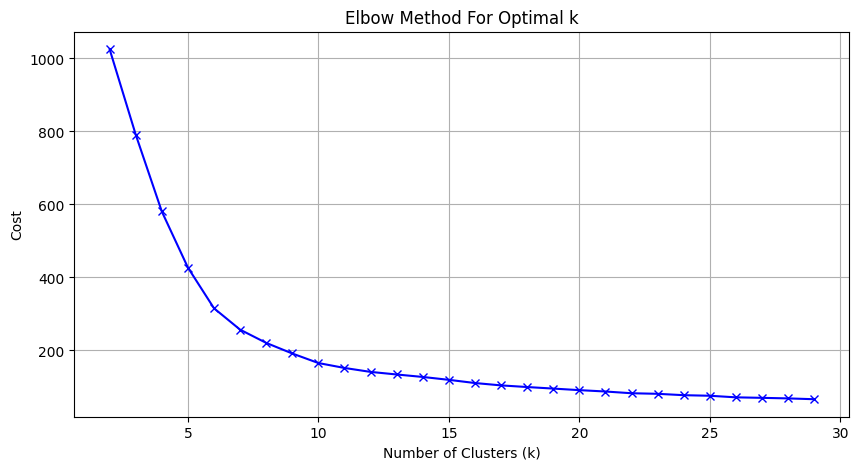

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow method (for reference only, obsolete in the paper)
# Run KMeans for a range of k values and collect the cost values
cost = []
sil_scores = []
K_range = range(2, 30, 1)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(umap_embeddings)
    cost.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(umap_embeddings, labels))

# Plot the cost against the number of clusters
plt.figure(figsize=(10, 5))
plt.plot(K_range, cost, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

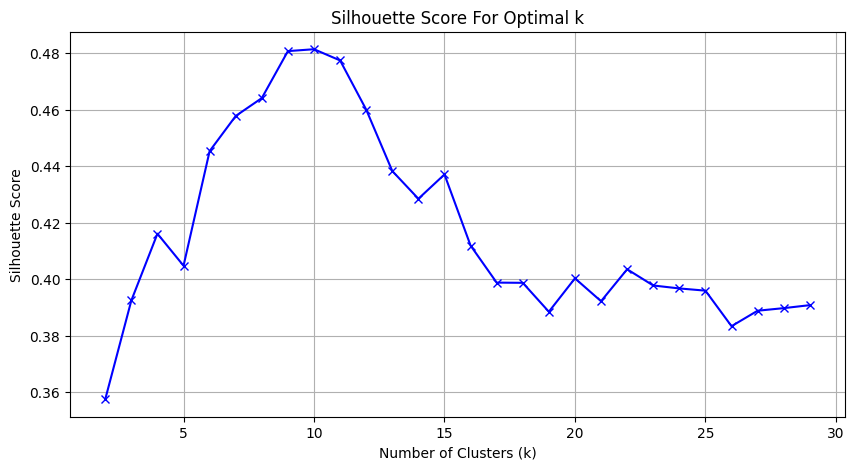

In [55]:
# Silhouette method
# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(10, 5))
plt.plot(K_range, sil_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.grid()
plt.show()

Tuning for UMAP by fixing K-means (K=10)

In [38]:
n_components_rng = range(5, 85, 5)
n_neighbors_rng = range(5, 35, 5)

results = [["n_neighbors", "n_components", "total_clusters", "total_outliers", "min_cluster_size", "max_cluster_size", "avg_cluster_size", "sil_ex", "sil_in", "cal_ex", 
            "cal_in", "div_score", "c_v_score", "u_mass_score", "uci_score", "npmi_score"]]
for neighbor in tqdm(n_neighbors_rng):
    for component in tqdm(n_components_rng):

        topic_model = BERTopic(
        
            # Pipeline models
            embedding_model=None,
            umap_model=get_umap(n_components=component, n_neighbors=neighbor), # Dimension Reduction method
            hdbscan_model=get_kmeans(n_clusters=10), # main Clustering algorithm
            vectorizer_model=get_Vectorizer(ngram_range=(1, 2), stop_words=stop_words_cust),
            representation_model=None,
        
            # Hyperparameters
            top_n_words=20,
            verbose = False
        )
        
        # Train model
        topics, probs = topic_model.fit_transform(docs, text_embeddings)

        # Retrieve meta data
        counter = topic_model.topic_sizes_.copy()
        total_clusters = max(topics) + 1
        try:
            total_outliers = counter.pop(-1)
        except:
            total_outliers = 0
        min_cluster_size = min(counter.values())
        max_cluster_size = max(counter.values())
        avg_cluster_size = sum(counter.values())/total_clusters

        # Extract the Text Embeddingsand Labels for exclude/include outliers
        indices = [index for index, topic in enumerate(topics) if topic != -1]
        X = text_embeddings[np.array(indices)]
        labels = [topic for index, topic in enumerate(topics) if topic != -1]
        
        indices_ = [index for index, topic in enumerate(topics)]
        X_ = text_embeddings[np.array(indices_)]
        labels_ = [topic for index, topic in enumerate(topics)]
        
        # Calculate silhouette and CH score
        sil_ex = silhouette_score(X, labels)
        ch_ex = calinski_harabasz_score(X, labels)
        sil_in = silhouette_score(X_, labels_)
        ch_in = calinski_harabasz_score(X_, labels_)

        # Compute Topic Diversity score by OCTIS
        bertopic_topics = [[vals[0] for vals in topic_model.get_topic(i)[:10]] for i in range(len(set(topics)) - 1)]
        output_tm = {"topics": bertopic_topics}
        topic_diversity = TopicDiversity(topk=10)
        div_score = topic_diversity.score(output_tm)

        # Extract vectorizer and analyzer from BERTopic
        vectorizer = topic_model.vectorizer_model
        analyzer = vectorizer.build_analyzer()
        
        # Extract features for Topic Coherence evaluation
        words = vectorizer.get_feature_names_out()
        tokens = [analyzer(doc) for doc in docs]
        #tokens = [analyzer(doc) for doc in cleaned_docs]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]
        topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                       for topic in range(len(set(topics))-1)]
        
        # Compute Topic Coherence Scores by Gensim
        c_v = CoherenceModel(topics=topic_words, topn=10,
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='c_v')
        u_mass = CoherenceModel(topics=topic_words, topn=10,
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='u_mass')
        uci = CoherenceModel(topics=topic_words, topn=10,
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='c_uci')
        npmi = CoherenceModel(topics=topic_words, topn=10,
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='c_npmi')
        c_v_score = c_v.get_coherence()
        u_mass_score = u_mass.get_coherence()
        uci_score = uci.get_coherence()
        npmi_score = npmi.get_coherence()

        result = [neighbor, component, total_clusters, total_outliers, min_cluster_size, max_cluster_size, avg_cluster_size, 
                  sil_ex, sil_in, ch_ex, ch_in, div_score, c_v_score, u_mass_score, uci_score, npmi_score]
        results.append(result)

  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:10:12 2023 Construct fuzzy simplicial set
Fri Jul 21 00:10:12 2023 Finding Nearest Neighbors
Fri Jul 21 00:10:12 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:10:12 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  28%| ██▊        139/500 [00:00]

Epochs completed:  55%| █████▌     276/500 [00:00]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:10:14,128 - BERTopic - Reduced dimensionality
2023-07-21 00:10:14,135 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:10:14 2023 Finished embedding



  6%|▋         | 1/16 [00:41<10:20, 41.40s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:10:54 2023 Construct fuzzy simplicial set
Fri Jul 21 00:10:54 2023 Finding Nearest Neighbors
Fri Jul 21 00:10:54 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:10:54 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  25%| ██▌        126/500 [00:00]

Epochs completed:  50%| █████      250/500 [00:00]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:10:55,428 - BERTopic - Reduced dimensionality
2023-07-21 00:10:55,436 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:10:55 2023 Finished embedding



 12%|█▎        | 2/16 [01:21<09:29, 40.66s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:11:34 2023 Construct fuzzy simplicial set
Fri Jul 21 00:11:34 2023 Finding Nearest Neighbors
Fri Jul 21 00:11:34 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:11:34 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  22%| ██▏        110/500 [00:00]

Epochs completed:  43%| ████▎      216/500 [00:00]

Epochs completed:  65%| ██████▍    323/500 [00:00]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:11:35,644 - BERTopic - Reduced dimensionality
2023-07-21 00:11:35,651 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:11:35 2023 Finished embedding



 19%|█▉        | 3/16 [02:01<08:43, 40.29s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:12:14 2023 Construct fuzzy simplicial set
Fri Jul 21 00:12:14 2023 Finding Nearest Neighbors
Fri Jul 21 00:12:14 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:12:14 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  20%| ██         102/500 [00:00]

Epochs completed:  40%| ████       201/500 [00:00]

Epochs completed:  60%| █████▉     298/500 [00:00]

Epochs completed:  77%| ███████▋   383/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:12:15,567 - BERTopic - Reduced dimensionality
2023-07-21 00:12:15,576 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:12:15 2023 Finished embedding



 25%|██▌       | 4/16 [02:41<08:04, 40.38s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:12:54 2023 Construct fuzzy simplicial set
Fri Jul 21 00:12:54 2023 Finding Nearest Neighbors
Fri Jul 21 00:12:54 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:12:54 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  19%| █▉         96/500 [00:00]

Epochs completed:  38%| ███▊       190/500 [00:01]

Epochs completed:  57%| █████▋     284/500 [00:01]

Epochs completed:  75%| ███████▌   377/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:12:56,272 - BERTopic - Reduced dimensionality
2023-07-21 00:12:56,279 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:12:56 2023 Finished embedding



 31%|███▏      | 5/16 [03:22<07:24, 40.37s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:13:35 2023 Construct fuzzy simplicial set
Fri Jul 21 00:13:35 2023 Finding Nearest Neighbors
Fri Jul 21 00:13:35 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:13:35 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  16%| █▌         80/500 [00:00]

Epochs completed:  31%| ███▏       157/500 [00:00]

Epochs completed:  47%| ████▋      233/500 [00:00]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  77%| ███████▋   385/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:13:36,554 - BERTopic - Reduced dimensionality
2023-07-21 00:13:36,564 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:13:36 2023 Finished embedding



 38%|███▊      | 6/16 [04:02<06:44, 40.40s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:14:15 2023 Construct fuzzy simplicial set
Fri Jul 21 00:14:15 2023 Finding Nearest Neighbors
Fri Jul 21 00:14:15 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:14:15 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  20%| ██         100/500 [00:00]

Epochs completed:  40%| ████       200/500 [00:00]

Epochs completed:  60%| ██████     300/500 [00:00]

Epochs completed:  80%| ███████▉   399/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:14:16,835 - BERTopic - Reduced dimensionality
2023-07-21 00:14:16,842 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:14:16 2023 Finished embedding



 44%|████▍     | 7/16 [04:43<06:04, 40.46s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:14:56 2023 Construct fuzzy simplicial set
Fri Jul 21 00:14:56 2023 Finding Nearest Neighbors
Fri Jul 21 00:14:56 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:14:56 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  19%| █▉         94/500 [00:00]

Epochs completed:  38%| ███▊       188/500 [00:01]

Epochs completed:  56%| █████▌     280/500 [00:01]

Epochs completed:  75%| ███████▍   373/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:14:57,745 - BERTopic - Reduced dimensionality
2023-07-21 00:14:57,753 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:14:57 2023 Finished embedding



 50%|█████     | 8/16 [05:23<05:23, 40.40s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:15:36 2023 Construct fuzzy simplicial set
Fri Jul 21 00:15:36 2023 Finding Nearest Neighbors
Fri Jul 21 00:15:36 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:15:36 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  16%| █▋         82/500 [00:00]

Epochs completed:  31%| ███        156/500 [00:00]

Epochs completed:  47%| ████▋      235/500 [00:00]

Epochs completed:  63%| ██████▎    315/500 [00:01]

Epochs completed:  79%| ███████▉   394/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:15:37,827 - BERTopic - Reduced dimensionality
2023-07-21 00:15:37,835 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:15:37 2023 Finished embedding



 56%|█████▋    | 9/16 [06:03<04:42, 40.33s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:16:16 2023 Construct fuzzy simplicial set
Fri Jul 21 00:16:16 2023 Finding Nearest Neighbors
Fri Jul 21 00:16:16 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:16:16 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▌         76/500 [00:00]

Epochs completed:  30%| ██▉        149/500 [00:00]

Epochs completed:  44%| ████▎      218/500 [00:00]

Epochs completed:  59%| █████▊     293/500 [00:01]

Epochs completed:  73%| ███████▎   367/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:16:18,076 - BERTopic - Reduced dimensionality
2023-07-21 00:16:18,083 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:16:18 2023 Finished embedding



 62%|██████▎   | 10/16 [06:44<04:02, 40.42s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:16:57 2023 Construct fuzzy simplicial set
Fri Jul 21 00:16:57 2023 Finding Nearest Neighbors
Fri Jul 21 00:16:57 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:16:57 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         71/500 [00:00]

Epochs completed:  28%| ██▊        139/500 [00:01]

Epochs completed:  40%| ████       201/500 [00:01]

Epochs completed:  54%| █████▍     269/500 [00:01]

Epochs completed:  68%| ██████▊    338/500 [00:01]

Epochs completed:  81%| ████████   406/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:16:58,966 - BERTopic - Reduced dimensionality
2023-07-21 00:16:58,976 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:16:58 2023 Finished embedding



 69%|██████▉   | 11/16 [07:25<03:23, 40.63s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:17:38 2023 Construct fuzzy simplicial set
Fri Jul 21 00:17:38 2023 Finding Nearest Neighbors
Fri Jul 21 00:17:38 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:17:38 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         66/500 [00:00]

Epochs completed:  26%| ██▋        132/500 [00:00]

Epochs completed:  39%| ███▉       195/500 [00:00]

Epochs completed:  52%| █████▏     261/500 [00:01]

Epochs completed:  65%| ██████▌    327/500 [00:01]

Epochs completed:  79%| ███████▊   393/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:17:39,850 - BERTopic - Reduced dimensionality
2023-07-21 00:17:39,858 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:17:39 2023 Finished embedding



 75%|███████▌  | 12/16 [08:05<02:41, 40.46s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:18:18 2023 Construct fuzzy simplicial set
Fri Jul 21 00:18:18 2023 Finding Nearest Neighbors
Fri Jul 21 00:18:18 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:18:18 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  18%| █▊         88/500 [00:00]

Epochs completed:  35%| ███▍       173/500 [00:00]

Epochs completed:  52%| █████▏     258/500 [00:00]

Epochs completed:  69%| ██████▊    343/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:18:19,752 - BERTopic - Reduced dimensionality
2023-07-21 00:18:19,759 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:18:19 2023 Finished embedding



 81%|████████▏ | 13/16 [08:46<02:01, 40.46s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:18:58 2023 Construct fuzzy simplicial set
Fri Jul 21 00:18:58 2023 Finding Nearest Neighbors
Fri Jul 21 00:18:58 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:18:58 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  16%| █▌         79/500 [00:00]

Epochs completed:  31%| ███        155/500 [00:00]

Epochs completed:  46%| ████▋      232/500 [00:00]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  77%| ███████▋   385/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:19:00,281 - BERTopic - Reduced dimensionality
2023-07-21 00:19:00,289 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:19:00 2023 Finished embedding



 88%|████████▊ | 14/16 [09:26<01:20, 40.41s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:19:39 2023 Construct fuzzy simplicial set
Fri Jul 21 00:19:39 2023 Finding Nearest Neighbors
Fri Jul 21 00:19:39 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:19:39 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▍         74/500 [00:00]

Epochs completed:  29%| ██▉        146/500 [00:01]

Epochs completed:  44%| ████▎      218/500 [00:01]

Epochs completed:  58%| █████▊     289/500 [00:01]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:19:40,838 - BERTopic - Reduced dimensionality
2023-07-21 00:19:40,846 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:19:40 2023 Finished embedding



 94%|█████████▍| 15/16 [10:07<00:40, 40.52s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=5, random_state=42, verbose=True)
Fri Jul 21 00:20:19 2023 Construct fuzzy simplicial set
Fri Jul 21 00:20:20 2023 Finding Nearest Neighbors
Fri Jul 21 00:20:20 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:20:20 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         71/500 [00:00]

Epochs completed:  28%| ██▊        140/500 [00:00]

Epochs completed:  42%| ████▏      209/500 [00:00]

Epochs completed:  55%| █████▍     273/500 [00:00]

Epochs completed:  68%| ██████▊    342/500 [00:01]

Epochs completed:  82%| ████████▏  411/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:20:21,416 - BERTopic - Reduced dimensionality
2023-07-21 00:20:21,424 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:20:21 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:21:00 2023 Construct fuzzy simplicial set
Fri Jul 21 00:21:00 2023 Finding Nearest Neighbors
Fri Jul 21 00:21:00 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:21:00 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  20%| █▉         98/500 [00:00]

Epochs completed:  39%| ███▉       194/500 [00:00]

Epochs completed:  58%| █████▊     290/500 [00:00]

Epochs completed:  77%| ███████▋   386/500 [00:00]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:21:01,774 - BERTopic - Reduced dimensionality
2023-07-21 00:21:01,782 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:21:01 2023 Finished embedding



  6%|▋         | 1/16 [00:40<10:00, 40.07s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:21:40 2023 Construct fuzzy simplicial set
Fri Jul 21 00:21:40 2023 Finding Nearest Neighbors
Fri Jul 21 00:21:40 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:21:40 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  18%| █▊         89/500 [00:00]

Epochs completed:  35%| ███▌       175/500 [00:01]

Epochs completed:  52%| █████▏     262/500 [00:01]

Epochs completed:  70%| ██████▉    348/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:21:42,114 - BERTopic - Reduced dimensionality
2023-07-21 00:21:42,123 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:21:42 2023 Finished embedding



 12%|█▎        | 2/16 [01:20<09:21, 40.08s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:22:20 2023 Construct fuzzy simplicial set
Fri Jul 21 00:22:20 2023 Finding Nearest Neighbors
Fri Jul 21 00:22:20 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:22:20 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▌         76/500 [00:00]

Epochs completed:  28%| ██▊        141/500 [00:00]

Epochs completed:  43%| ████▎      214/500 [00:00]

Epochs completed:  57%| █████▋     287/500 [00:01]

Epochs completed:  72%| ███████▏   359/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:22:22,120 - BERTopic - Reduced dimensionality
2023-07-21 00:22:22,128 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:22:22 2023 Finished embedding



 19%|█▉        | 3/16 [02:00<08:43, 40.26s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:23:01 2023 Construct fuzzy simplicial set
Fri Jul 21 00:23:01 2023 Finding Nearest Neighbors
Fri Jul 21 00:23:01 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:23:01 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         71/500 [00:00]

Epochs completed:  28%| ██▊        139/500 [00:00]

Epochs completed:  41%| ████▏      207/500 [00:00]

Epochs completed:  55%| █████▌     276/500 [00:01]

Epochs completed:  69%| ██████▉    345/500 [00:01]

Epochs completed:  83%| ████████▎  414/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:23:02,641 - BERTopic - Reduced dimensionality
2023-07-21 00:23:02,648 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:23:02 2023 Finished embedding



 25%|██▌       | 4/16 [02:40<08:02, 40.21s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:23:41 2023 Construct fuzzy simplicial set
Fri Jul 21 00:23:41 2023 Finding Nearest Neighbors
Fri Jul 21 00:23:41 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:23:41 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         65/500 [00:00]

Epochs completed:  26%| ██▌        128/500 [00:00]

Epochs completed:  38%| ███▊       191/500 [00:00]

Epochs completed:  51%| █████      254/500 [00:01]

Epochs completed:  63%| ██████▎    317/500 [00:01]

Epochs completed:  76%| ███████▌   380/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:23:42,847 - BERTopic - Reduced dimensionality
2023-07-21 00:23:42,855 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:23:42 2023 Finished embedding



 31%|███▏      | 5/16 [03:21<07:24, 40.38s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:24:21 2023 Construct fuzzy simplicial set
Fri Jul 21 00:24:22 2023 Finding Nearest Neighbors
Fri Jul 21 00:24:22 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:24:22 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          56/500 [00:00]

Epochs completed:  22%| ██▏        109/500 [00:00]

Epochs completed:  32%| ███▏       162/500 [00:00]

Epochs completed:  43%| ████▎      215/500 [00:01]

Epochs completed:  54%| █████▎     268/500 [00:01]

Epochs completed:  64%| ██████▍    321/500 [00:01]

Epochs completed:  75%| ███████▍   374/500 [00:01]

Epochs completed:  85%| ████████▌  427/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:24:23,662 - BERTopic - Reduced dimensionality
2023-07-21 00:24:23,670 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:24:23 2023 Finished embedding



 38%|███▊      | 6/16 [04:02<06:47, 40.72s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:25:03 2023 Construct fuzzy simplicial set
Fri Jul 21 00:25:03 2023 Finding Nearest Neighbors
Fri Jul 21 00:25:03 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:25:03 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         70/500 [00:00]

Epochs completed:  27%| ██▋        137/500 [00:00]

Epochs completed:  41%| ████       204/500 [00:00]

Epochs completed:  54%| █████▍     272/500 [00:01]

Epochs completed:  68%| ██████▊    339/500 [00:01]

Epochs completed:  81%| ████████   405/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:25:04,903 - BERTopic - Reduced dimensionality
2023-07-21 00:25:04,913 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:25:04 2023 Finished embedding



 44%|████▍     | 7/16 [04:44<06:10, 41.14s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:25:45 2023 Construct fuzzy simplicial set
Fri Jul 21 00:25:45 2023 Finding Nearest Neighbors
Fri Jul 21 00:25:45 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:25:45 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         66/500 [00:00]

Epochs completed:  26%| ██▌        129/500 [00:00]

Epochs completed:  39%| ███▊       193/500 [00:00]

Epochs completed:  51%| █████▏     257/500 [00:01]

Epochs completed:  64%| ██████▍    320/500 [00:01]

Epochs completed:  77%| ███████▋   384/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:25:46,884 - BERTopic - Reduced dimensionality
2023-07-21 00:25:46,891 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:25:46 2023 Finished embedding



 50%|█████     | 8/16 [05:25<05:27, 41.00s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:26:25 2023 Construct fuzzy simplicial set
Fri Jul 21 00:26:26 2023 Finding Nearest Neighbors
Fri Jul 21 00:26:26 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:26:26 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          56/500 [00:00]

Epochs completed:  22%| ██▏        109/500 [00:01]

Epochs completed:  33%| ███▎       163/500 [00:01]

Epochs completed:  43%| ████▎      217/500 [00:01]

Epochs completed:  54%| █████▍     271/500 [00:01]

Epochs completed:  65%| ██████▌    325/500 [00:01]

Epochs completed:  76%| ███████▌   379/500 [00:01]

Epochs completed:  87%| ████████▋  433/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:26:27,982 - BERTopic - Reduced dimensionality
2023-07-21 00:26:27,991 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:26:27 2023 Finished embedding



 56%|█████▋    | 9/16 [06:10<04:55, 42.21s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:27:10 2023 Construct fuzzy simplicial set
Fri Jul 21 00:27:11 2023 Finding Nearest Neighbors
Fri Jul 21 00:27:11 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:27:11 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          53/500 [00:00]

Epochs completed:  21%| ██         104/500 [00:00]

Epochs completed:  31%| ███        155/500 [00:00]

Epochs completed:  41%| ████       206/500 [00:01]

Epochs completed:  51%| █████▏     257/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  72%| ███████▏   359/500 [00:01]

Epochs completed:  82%| ████████▏  410/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:27:12,702 - BERTopic - Reduced dimensionality
2023-07-21 00:27:12,711 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:27:12 2023 Finished embedding



 62%|██████▎   | 10/16 [06:51<04:11, 41.97s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:27:52 2023 Construct fuzzy simplicial set
Fri Jul 21 00:27:52 2023 Finding Nearest Neighbors
Fri Jul 21 00:27:52 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:27:52 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          48/500 [00:00]

Epochs completed:  19%| █▉         94/500 [00:00]

Epochs completed:  28%| ██▊        141/500 [00:00]

Epochs completed:  38%| ███▊       188/500 [00:00]

Epochs completed:  47%| ████▋      235/500 [00:01]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  66%| ██████▌    329/500 [00:01]

Epochs completed:  75%| ███████▌   376/500 [00:01]

Epochs completed:  85%| ████████▍  423/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:27:54,179 - BERTopic - Reduced dimensionality
2023-07-21 00:27:54,187 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:27:54 2023 Finished embedding



 69%|██████▉   | 11/16 [07:32<03:28, 41.69s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:28:33 2023 Construct fuzzy simplicial set
Fri Jul 21 00:28:33 2023 Finding Nearest Neighbors
Fri Jul 21 00:28:33 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:28:33 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         92/500 [00:01]

Epochs completed:  27%| ██▋        137/500 [00:01]

Epochs completed:  36%| ███▋       182/500 [00:01]

Epochs completed:  45%| ████▌      227/500 [00:01]

Epochs completed:  54%| █████▍     272/500 [00:01]

Epochs completed:  63%| ██████▎    317/500 [00:01]

Epochs completed:  72%| ███████▏   361/500 [00:01]

Epochs completed:  81%| ████████   406/500 [00:01]

Epochs completed:  90%| █████████  450/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:28:35,536 - BERTopic - Reduced dimensionality
2023-07-21 00:28:35,550 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:28:35 2023 Finished embedding



 75%|███████▌  | 12/16 [08:14<02:46, 41.63s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:29:14 2023 Construct fuzzy simplicial set
Fri Jul 21 00:29:15 2023 Finding Nearest Neighbors
Fri Jul 21 00:29:15 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:29:15 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         60/500 [00:00]

Epochs completed:  24%| ██▎        118/500 [00:00]

Epochs completed:  35%| ███▌       176/500 [00:00]

Epochs completed:  47%| ████▋      234/500 [00:01]

Epochs completed:  58%| █████▊     292/500 [00:01]

Epochs completed:  70%| ███████    350/500 [00:01]

Epochs completed:  82%| ████████▏  408/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:29:16,533 - BERTopic - Reduced dimensionality
2023-07-21 00:29:16,541 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:29:16 2023 Finished embedding



 81%|████████▏ | 13/16 [08:54<02:03, 41.21s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:29:55 2023 Construct fuzzy simplicial set
Fri Jul 21 00:29:55 2023 Finding Nearest Neighbors
Fri Jul 21 00:29:55 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:29:55 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          55/500 [00:00]

Epochs completed:  21%| ██▏        107/500 [00:00]

Epochs completed:  32%| ███▏       159/500 [00:00]

Epochs completed:  42%| ████▏      211/500 [00:01]

Epochs completed:  53%| █████▎     263/500 [00:01]

Epochs completed:  63%| ██████▎    315/500 [00:01]

Epochs completed:  73%| ███████▎   367/500 [00:01]

Epochs completed:  84%| ████████▍  419/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:29:56,901 - BERTopic - Reduced dimensionality
2023-07-21 00:29:56,909 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:29:56 2023 Finished embedding



 88%|████████▊ | 14/16 [09:35<01:21, 40.97s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:30:35 2023 Construct fuzzy simplicial set
Fri Jul 21 00:30:35 2023 Finding Nearest Neighbors
Fri Jul 21 00:30:35 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:30:35 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          52/500 [00:00]

Epochs completed:  20%| ██         101/500 [00:00]

Epochs completed:  30%| ███        151/500 [00:00]

Epochs completed:  40%| ████       200/500 [00:01]

Epochs completed:  50%| ████▉      249/500 [00:01]

Epochs completed:  60%| █████▉     299/500 [00:01]

Epochs completed:  70%| ██████▉    348/500 [00:01]

Epochs completed:  80%| ███████▉   398/500 [00:01]

Epochs completed:  89%| ████████▉  447/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:30:37,369 - BERTopic - Reduced dimensionality
2023-07-21 00:30:37,378 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:30:37 2023 Finished embedding



 94%|█████████▍| 15/16 [10:15<00:40, 40.82s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=10, random_state=42, verbose=True)
Fri Jul 21 00:31:15 2023 Construct fuzzy simplicial set
Fri Jul 21 00:31:16 2023 Finding Nearest Neighbors
Fri Jul 21 00:31:16 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:31:16 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          49/500 [00:00]

Epochs completed:  19%| █▉         95/500 [00:01]

Epochs completed:  28%| ██▊        142/500 [00:01]

Epochs completed:  38%| ███▊       188/500 [00:01]

Epochs completed:  47%| ████▋      234/500 [00:01]

Epochs completed:  56%| █████▌     281/500 [00:01]

Epochs completed:  65%| ██████▌    327/500 [00:01]

Epochs completed:  75%| ███████▍   374/500 [00:01]

Epochs completed:  84%| ████████▍  421/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:31:18,110 - BERTopic - Reduced dimensionality
2023-07-21 00:31:18,123 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:31:18 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, random_state=42, verbose=True)
Fri Jul 21 00:31:57 2023 Construct fuzzy simplicial set
Fri Jul 21 00:31:58 2023 Finding Nearest Neighbors
Fri Jul 21 00:31:58 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:31:58 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▌         76/500 [00:00]

Epochs completed:  28%| ██▊        142/500 [00:00]

Epochs completed:  43%| ████▎      217/500 [00:00]

Epochs completed:  57%| █████▋     284/500 [00:01]

Epochs completed:  71%| ███████    355/500 [00:01]

Epochs completed:  86%| ████████▌  428/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:31:59,466 - BERTopic - Reduced dimensionality
2023-07-21 00:31:59,474 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:31:59 2023 Finished embedding



  6%|▋         | 1/16 [00:41<10:16, 41.08s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, random_state=42, verbose=True)
Fri Jul 21 00:32:39 2023 Construct fuzzy simplicial set
Fri Jul 21 00:32:39 2023 Finding Nearest Neighbors
Fri Jul 21 00:32:39 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:32:39 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▌         75/500 [00:00]

Epochs completed:  29%| ██▉        147/500 [00:00]

Epochs completed:  44%| ████▍      219/500 [00:00]

Epochs completed:  58%| █████▊     290/500 [00:00]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:32:40,489 - BERTopic - Reduced dimensionality
2023-07-21 00:32:40,497 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:32:40 2023 Finished embedding



 12%|█▎        | 2/16 [01:21<09:26, 40.43s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, random_state=42, verbose=True)
Fri Jul 21 00:33:19 2023 Construct fuzzy simplicial set
Fri Jul 21 00:33:19 2023 Finding Nearest Neighbors
Fri Jul 21 00:33:19 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:33:19 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         64/500 [00:00]

Epochs completed:  25%| ██▌        125/500 [00:01]

Epochs completed:  37%| ███▋       186/500 [00:01]

Epochs completed:  49%| ████▉      247/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  74%| ███████▍   369/500 [00:01]

Epochs completed:  86%| ████████▌  428/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:33:20,883 - BERTopic - Reduced dimensionality
2023-07-21 00:33:20,890 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:33:20 2023 Finished embedding



 19%|█▉        | 3/16 [02:01<08:44, 40.33s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, random_state=42, verbose=True)
Fri Jul 21 00:33:59 2023 Construct fuzzy simplicial set
Fri Jul 21 00:33:59 2023 Finding Nearest Neighbors
Fri Jul 21 00:33:59 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:33:59 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         60/500 [00:00]

Epochs completed:  23%| ██▎        117/500 [00:00]

Epochs completed:  35%| ███▍       173/500 [00:00]

Epochs completed:  46%| ████▌      229/500 [00:01]

Epochs completed:  57%| █████▋     286/500 [00:01]

Epochs completed:  69%| ██████▊    343/500 [00:01]

Epochs completed:  80%| ███████▉   399/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:34:00,885 - BERTopic - Reduced dimensionality
2023-07-21 00:34:00,892 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:34:00 2023 Finished embedding



 25%|██▌       | 4/16 [02:43<08:11, 40.94s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, random_state=42, verbose=True)
Fri Jul 21 00:34:41 2023 Construct fuzzy simplicial set
Fri Jul 21 00:34:41 2023 Finding Nearest Neighbors
Fri Jul 21 00:34:41 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:34:41 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          56/500 [00:00]

Epochs completed:  22%| ██▏        109/500 [00:00]

Epochs completed:  32%| ███▏       162/500 [00:00]

Epochs completed:  43%| ████▎      214/500 [00:01]

Epochs completed:  53%| █████▎     267/500 [00:01]

Epochs completed:  64%| ██████▍    320/500 [00:01]

Epochs completed:  75%| ███████▍   374/500 [00:01]

Epochs completed:  85%| ████████▌  427/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:34:42,821 - BERTopic - Reduced dimensionality
2023-07-21 00:34:42,829 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:34:42 2023 Finished embedding



 31%|███▏      | 5/16 [03:24<07:32, 41.10s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, random_state=42, verbose=True)
Fri Jul 21 00:35:22 2023 Construct fuzzy simplicial set
Fri Jul 21 00:35:22 2023 Finding Nearest Neighbors
Fri Jul 21 00:35:22 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:35:22 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         90/500 [00:00]

Epochs completed:  27%| ██▋        134/500 [00:01]

Epochs completed:  36%| ███▌       178/500 [00:01]

Epochs completed:  44%| ████▍      222/500 [00:01]

Epochs completed:  53%| █████▎     265/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  70%| ███████    351/500 [00:01]

Epochs completed:  79%| ███████▉   394/500 [00:01]

Epochs completed:  87%| ████████▋  437/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:35:24,536 - BERTopic - Reduced dimensionality
2023-07-21 00:35:24,544 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:35:24 2023 Finished embedding



 38%|███▊      | 6/16 [04:07<06:56, 41.64s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, random_state=42, verbose=True)
Fri Jul 21 00:36:05 2023 Construct fuzzy simplicial set
Fri Jul 21 00:36:05 2023 Finding Nearest Neighbors
Fri Jul 21 00:36:05 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:36:05 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         59/500 [00:00]

Epochs completed:  23%| ██▎        116/500 [00:01]

Epochs completed:  34%| ███▍       172/500 [00:01]

Epochs completed:  46%| ████▌      229/500 [00:01]

Epochs completed:  57%| █████▋     286/500 [00:01]

Epochs completed:  68%| ██████▊    342/500 [00:01]

Epochs completed:  80%| ███████▉   398/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:36:07,065 - BERTopic - Reduced dimensionality
2023-07-21 00:36:07,074 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:36:07 2023 Finished embedding



 44%|████▍     | 7/16 [04:47<06:11, 41.32s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, random_state=42, verbose=True)
Fri Jul 21 00:36:45 2023 Construct fuzzy simplicial set
Fri Jul 21 00:36:46 2023 Finding Nearest Neighbors
Fri Jul 21 00:36:46 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:36:46 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          55/500 [00:00]

Epochs completed:  22%| ██▏        108/500 [00:00]

Epochs completed:  32%| ███▏       161/500 [00:00]

Epochs completed:  43%| ████▎      214/500 [00:01]

Epochs completed:  53%| █████▎     267/500 [00:01]

Epochs completed:  64%| ██████▍    320/500 [00:01]

Epochs completed:  75%| ███████▍   373/500 [00:01]

Epochs completed:  85%| ████████▌  425/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:36:47,616 - BERTopic - Reduced dimensionality
2023-07-21 00:36:47,635 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:36:47 2023 Finished embedding



 50%|█████     | 8/16 [05:28<05:27, 40.95s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, random_state=42, verbose=True)
Fri Jul 21 00:37:25 2023 Construct fuzzy simplicial set
Fri Jul 21 00:37:26 2023 Finding Nearest Neighbors
Fri Jul 21 00:37:26 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:37:26 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          49/500 [00:00]

Epochs completed:  19%| █▉         94/500 [00:00]

Epochs completed:  28%| ██▊        139/500 [00:00]

Epochs completed:  37%| ███▋       184/500 [00:01]

Epochs completed:  46%| ████▌      229/500 [00:01]

Epochs completed:  55%| █████▍     274/500 [00:01]

Epochs completed:  64%| ██████▍    320/500 [00:01]

Epochs completed:  73%| ███████▎   365/500 [00:01]

Epochs completed:  82%| ████████▏  410/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:37:27,895 - BERTopic - Reduced dimensionality
2023-07-21 00:37:27,905 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:37:27 2023 Finished embedding



 56%|█████▋    | 9/16 [06:08<04:45, 40.72s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, random_state=42, verbose=True)
Fri Jul 21 00:38:06 2023 Construct fuzzy simplicial set
Fri Jul 21 00:38:06 2023 Finding Nearest Neighbors
Fri Jul 21 00:38:06 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:38:06 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          45/500 [00:00]

Epochs completed:  18%| █▊         88/500 [00:01]

Epochs completed:  26%| ██▌        130/500 [00:01]

Epochs completed:  35%| ███▍       173/500 [00:01]

Epochs completed:  43%| ████▎      216/500 [00:01]

Epochs completed:  52%| █████▏     258/500 [00:01]

Epochs completed:  60%| ██████     301/500 [00:01]

Epochs completed:  69%| ██████▉    344/500 [00:01]

Epochs completed:  77%| ███████▋   387/500 [00:01]

Epochs completed:  86%| ████████▌  430/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 00:38:08,449 - BERTopic - Reduced dimensionality
2023-07-21 00:38:08,457 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:38:08 2023 Finished embedding



 62%|██████▎   | 10/16 [06:50<04:06, 41.07s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, random_state=42, verbose=True)
Fri Jul 21 00:38:48 2023 Construct fuzzy simplicial set
Fri Jul 21 00:38:48 2023 Finding Nearest Neighbors
Fri Jul 21 00:38:48 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:38:48 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          42/500 [00:00]

Epochs completed:  16%| █▋         82/500 [00:00]

Epochs completed:  24%| ██▍        121/500 [00:00]

Epochs completed:  32%| ███▏       160/500 [00:01]

Epochs completed:  40%| ███▉       199/500 [00:01]

Epochs completed:  48%| ████▊      238/500 [00:01]

Epochs completed:  55%| █████▌     277/500 [00:01]

Epochs completed:  63%| ██████▎    317/500 [00:01]

Epochs completed:  71%| ███████    356/500 [00:01]

Epochs completed:  79%| ███████▉   395/500 [00:01]

Epochs completed:  87%| ████████▋  434/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:38:50,144 - BERTopic - Reduced dimensionality
2023-07-21 00:38:50,153 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:38:50 2023 Finished embedding



 69%|██████▉   | 11/16 [07:32<03:26, 41.37s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, random_state=42, verbose=True)
Fri Jul 21 00:39:30 2023 Construct fuzzy simplicial set
Fri Jul 21 00:39:30 2023 Finding Nearest Neighbors
Fri Jul 21 00:39:30 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:39:30 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          40/500 [00:00]

Epochs completed:  16%| █▌         78/500 [00:00]

Epochs completed:  23%| ██▎        116/500 [00:00]

Epochs completed:  31%| ███        154/500 [00:01]

Epochs completed:  38%| ███▊       192/500 [00:01]

Epochs completed:  46%| ████▌      230/500 [00:01]

Epochs completed:  53%| █████▎     267/500 [00:01]

Epochs completed:  61%| ██████     305/500 [00:01]

Epochs completed:  69%| ██████▊    343/500 [00:01]

Epochs completed:  76%| ███████▌   380/500 [00:01]

Epochs completed:  84%| ████████▎  418/500 [00:01]

Epochs completed:  91%| █████████  456/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:39:32,228 - BERTopic - Reduced dimensionality
2023-07-21 00:39:32,240 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:39:32 2023 Finished embedding



 75%|███████▌  | 12/16 [08:12<02:44, 41.08s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, random_state=42, verbose=True)
Fri Jul 21 00:40:10 2023 Construct fuzzy simplicial set
Fri Jul 21 00:40:10 2023 Finding Nearest Neighbors
Fri Jul 21 00:40:10 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:40:10 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          52/500 [00:00]

Epochs completed:  20%| ██         101/500 [00:00]

Epochs completed:  30%| ███        150/500 [00:00]

Epochs completed:  40%| ███▉       198/500 [00:01]

Epochs completed:  49%| ████▉      247/500 [00:01]

Epochs completed:  59%| █████▉     296/500 [00:01]

Epochs completed:  69%| ██████▉    345/500 [00:01]

Epochs completed:  79%| ███████▉   394/500 [00:01]

Epochs completed:  89%| ████████▊  443/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:40:12,346 - BERTopic - Reduced dimensionality
2023-07-21 00:40:12,355 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:40:12 2023 Finished embedding



 81%|████████▏ | 13/16 [08:53<02:03, 41.01s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, random_state=42, verbose=True)
Fri Jul 21 00:40:51 2023 Construct fuzzy simplicial set
Fri Jul 21 00:40:51 2023 Finding Nearest Neighbors
Fri Jul 21 00:40:51 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:40:51 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         90/500 [00:01]

Epochs completed:  27%| ██▋        134/500 [00:01]

Epochs completed:  36%| ███▌       178/500 [00:01]

Epochs completed:  44%| ████▍      221/500 [00:01]

Epochs completed:  53%| █████▎     264/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  70%| ███████    352/500 [00:01]

Epochs completed:  79%| ███████▉   396/500 [00:01]

Epochs completed:  88%| ████████▊  440/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:40:53,561 - BERTopic - Reduced dimensionality
2023-07-21 00:40:53,569 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:40:53 2023 Finished embedding



 88%|████████▊ | 14/16 [09:34<01:22, 41.06s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, random_state=42, verbose=True)
Fri Jul 21 00:41:32 2023 Construct fuzzy simplicial set
Fri Jul 21 00:41:32 2023 Finding Nearest Neighbors
Fri Jul 21 00:41:32 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:41:32 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          44/500 [00:00]

Epochs completed:  17%| █▋         85/500 [00:00]

Epochs completed:  25%| ██▌        126/500 [00:00]

Epochs completed:  33%| ███▎       167/500 [00:01]

Epochs completed:  42%| ████▏      208/500 [00:01]

Epochs completed:  50%| ████▉      249/500 [00:01]

Epochs completed:  58%| █████▊     290/500 [00:01]

Epochs completed:  66%| ██████▌    331/500 [00:01]

Epochs completed:  74%| ███████▍   371/500 [00:01]

Epochs completed:  82%| ████████▏  412/500 [00:01]

Epochs completed:  91%| █████████  454/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:41:34,579 - BERTopic - Reduced dimensionality
2023-07-21 00:41:34,590 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:41:34 2023 Finished embedding



 94%|█████████▍| 15/16 [10:17<00:41, 41.55s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, random_state=42, verbose=True)
Fri Jul 21 00:42:15 2023 Construct fuzzy simplicial set
Fri Jul 21 00:42:15 2023 Finding Nearest Neighbors
Fri Jul 21 00:42:15 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:42:15 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          42/500 [00:00]

Epochs completed:  16%| █▋         82/500 [00:00]

Epochs completed:  24%| ██▍        122/500 [00:00]

Epochs completed:  32%| ███▏       161/500 [00:01]

Epochs completed:  40%| ████       201/500 [00:01]

Epochs completed:  48%| ████▊      241/500 [00:01]

Epochs completed:  56%| █████▌     281/500 [00:01]

Epochs completed:  64%| ██████▍    321/500 [00:01]

Epochs completed:  72%| ███████▏   361/500 [00:01]

Epochs completed:  80%| ████████   400/500 [00:01]

Epochs completed:  88%| ████████▊  440/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:42:17,296 - BERTopic - Reduced dimensionality
2023-07-21 00:42:17,304 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:42:17 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:42:56 2023 Construct fuzzy simplicial set
Fri Jul 21 00:42:57 2023 Finding Nearest Neighbors
Fri Jul 21 00:42:57 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:42:57 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  15%| █▌         75/500 [00:00]

Epochs completed:  29%| ██▉        146/500 [00:01]

Epochs completed:  44%| ████▎      218/500 [00:01]

Epochs completed:  58%| █████▊     290/500 [00:01]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:42:58,547 - BERTopic - Reduced dimensionality
2023-07-21 00:42:58,553 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:42:58 2023 Finished embedding



  6%|▋         | 1/16 [00:42<10:37, 42.49s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:43:39 2023 Construct fuzzy simplicial set
Fri Jul 21 00:43:39 2023 Finding Nearest Neighbors
Fri Jul 21 00:43:39 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:43:39 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         65/500 [00:00]

Epochs completed:  26%| ██▌        128/500 [00:00]

Epochs completed:  38%| ███▊       190/500 [00:00]

Epochs completed:  51%| █████      253/500 [00:01]

Epochs completed:  63%| ██████▎    316/500 [00:01]

Epochs completed:  76%| ███████▌   380/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:43:40,940 - BERTopic - Reduced dimensionality
2023-07-21 00:43:40,947 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:43:40 2023 Finished embedding



 12%|█▎        | 2/16 [01:22<09:37, 41.25s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:44:19 2023 Construct fuzzy simplicial set
Fri Jul 21 00:44:19 2023 Finding Nearest Neighbors
Fri Jul 21 00:44:19 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:44:19 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         59/500 [00:00]

Epochs completed:  22%| ██▏        112/500 [00:00]

Epochs completed:  33%| ███▎       167/500 [00:00]

Epochs completed:  44%| ████▍      219/500 [00:01]

Epochs completed:  55%| █████▍     274/500 [00:01]

Epochs completed:  66%| ██████▌    328/500 [00:01]

Epochs completed:  76%| ███████▌   380/500 [00:01]

Epochs completed:  87%| ████████▋  434/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:44:21,479 - BERTopic - Reduced dimensionality
2023-07-21 00:44:21,486 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:44:21 2023 Finished embedding



 19%|█▉        | 3/16 [02:05<09:02, 41.73s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:45:02 2023 Construct fuzzy simplicial set
Fri Jul 21 00:45:02 2023 Finding Nearest Neighbors
Fri Jul 21 00:45:02 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:45:02 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          54/500 [00:00]

Epochs completed:  21%| ██         105/500 [00:00]

Epochs completed:  31%| ███        156/500 [00:00]

Epochs completed:  41%| ████▏      207/500 [00:01]

Epochs completed:  52%| █████▏     258/500 [00:01]

Epochs completed:  62%| ██████▏    309/500 [00:01]

Epochs completed:  72%| ███████▏   360/500 [00:01]

Epochs completed:  82%| ████████▏  411/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:45:03,840 - BERTopic - Reduced dimensionality
2023-07-21 00:45:03,848 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:45:03 2023 Finished embedding



 25%|██▌       | 4/16 [02:46<08:19, 41.62s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:45:43 2023 Construct fuzzy simplicial set
Fri Jul 21 00:45:43 2023 Finding Nearest Neighbors
Fri Jul 21 00:45:43 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:45:43 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          51/500 [00:00]

Epochs completed:  20%| █▉         98/500 [00:01]

Epochs completed:  29%| ██▉        146/500 [00:01]

Epochs completed:  39%| ███▊       193/500 [00:01]

Epochs completed:  48%| ████▊      240/500 [00:01]

Epochs completed:  57%| █████▋     287/500 [00:01]

Epochs completed:  67%| ██████▋    335/500 [00:01]

Epochs completed:  76%| ███████▋   382/500 [00:01]

Epochs completed:  86%| ████████▌  429/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:45:45,595 - BERTopic - Reduced dimensionality
2023-07-21 00:45:45,604 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:45:45 2023 Finished embedding



 31%|███▏      | 5/16 [03:27<07:36, 41.49s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:46:24 2023 Construct fuzzy simplicial set
Fri Jul 21 00:46:24 2023 Finding Nearest Neighbors
Fri Jul 21 00:46:24 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:46:24 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▊          43/500 [00:00]

Epochs completed:  17%| █▋         83/500 [00:00]

Epochs completed:  25%| ██▍        123/500 [00:00]

Epochs completed:  33%| ███▎       163/500 [00:01]

Epochs completed:  41%| ████       203/500 [00:01]

Epochs completed:  49%| ████▊      243/500 [00:01]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  64%| ██████▍    322/500 [00:01]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed:  80%| ████████   402/500 [00:01]

Epochs completed:  88%| ████████▊  441/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:46:26,845 - BERTopic - Reduced dimensionality
2023-07-21 00:46:26,854 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:46:26 2023 Finished embedding



 38%|███▊      | 6/16 [04:09<06:55, 41.58s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:47:06 2023 Construct fuzzy simplicial set
Fri Jul 21 00:47:06 2023 Finding Nearest Neighbors
Fri Jul 21 00:47:06 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:47:06 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          54/500 [00:00]

Epochs completed:  21%| ██         104/500 [00:00]

Epochs completed:  31%| ███        155/500 [00:00]

Epochs completed:  41%| ████       206/500 [00:01]

Epochs completed:  51%| █████▏     257/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  72%| ███████▏   358/500 [00:01]

Epochs completed:  82%| ████████▏  408/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:47:08,267 - BERTopic - Reduced dimensionality
2023-07-21 00:47:08,281 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:47:08 2023 Finished embedding



 44%|████▍     | 7/16 [04:50<06:12, 41.34s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:47:47 2023 Construct fuzzy simplicial set
Fri Jul 21 00:47:47 2023 Finding Nearest Neighbors
Fri Jul 21 00:47:47 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:47:47 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          50/500 [00:00]

Epochs completed:  19%| █▉         97/500 [00:01]

Epochs completed:  29%| ██▉        145/500 [00:01]

Epochs completed:  38%| ███▊       192/500 [00:01]

Epochs completed:  48%| ████▊      239/500 [00:01]

Epochs completed:  57%| █████▋     287/500 [00:01]

Epochs completed:  67%| ██████▋    335/500 [00:01]

Epochs completed:  77%| ███████▋   383/500 [00:01]

Epochs completed:  86%| ████████▌  431/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:47:49,428 - BERTopic - Reduced dimensionality
2023-07-21 00:47:49,437 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:47:49 2023 Finished embedding



 50%|█████     | 8/16 [05:31<05:29, 41.23s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:48:28 2023 Construct fuzzy simplicial set
Fri Jul 21 00:48:28 2023 Finding Nearest Neighbors
Fri Jul 21 00:48:28 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:48:28 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          44/500 [00:00]

Epochs completed:  17%| █▋         84/500 [00:00]

Epochs completed:  25%| ██▍        124/500 [00:00]

Epochs completed:  33%| ███▎       165/500 [00:01]

Epochs completed:  41%| ████       205/500 [00:01]

Epochs completed:  49%| ████▉      245/500 [00:01]

Epochs completed:  57%| █████▋     285/500 [00:01]

Epochs completed:  65%| ██████▍    324/500 [00:01]

Epochs completed:  73%| ███████▎   364/500 [00:01]

Epochs completed:  81%| ████████   404/500 [00:01]

Epochs completed:  89%| ████████▉  444/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:48:30,401 - BERTopic - Reduced dimensionality
2023-07-21 00:48:30,411 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:48:30 2023 Finished embedding



 56%|█████▋    | 9/16 [06:12<04:48, 41.24s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:49:09 2023 Construct fuzzy simplicial set
Fri Jul 21 00:49:09 2023 Finding Nearest Neighbors
Fri Jul 21 00:49:09 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:49:09 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          42/500 [00:00]

Epochs completed:  16%| █▌         80/500 [00:00]

Epochs completed:  24%| ██▎        118/500 [00:00]

Epochs completed:  31%| ███        156/500 [00:01]

Epochs completed:  39%| ███▉       194/500 [00:01]

Epochs completed:  46%| ████▋      232/500 [00:01]

Epochs completed:  54%| █████▍     270/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  69%| ██████▉    346/500 [00:01]

Epochs completed:  77%| ███████▋   383/500 [00:01]

Epochs completed:  84%| ████████▍  421/500 [00:01]

Epochs completed:  92%| █████████▏ 459/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:49:11,718 - BERTopic - Reduced dimensionality
2023-07-21 00:49:11,727 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:49:11 2023 Finished embedding



 62%|██████▎   | 10/16 [06:53<04:05, 40.96s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:49:49 2023 Construct fuzzy simplicial set
Fri Jul 21 00:49:50 2023 Finding Nearest Neighbors
Fri Jul 21 00:49:50 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:49:50 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  14%| █▍         72/500 [00:00]

Epochs completed:  21%| ██▏        107/500 [00:00]

Epochs completed:  28%| ██▊        142/500 [00:01]

Epochs completed:  35%| ███▌       177/500 [00:01]

Epochs completed:  42%| ████▏      212/500 [00:01]

Epochs completed:  49%| ████▉      247/500 [00:01]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  63%| ██████▎    316/500 [00:01]

Epochs completed:  70%| ███████    351/500 [00:01]

Epochs completed:  77%| ███████▋   385/500 [00:01]

Epochs completed:  84%| ████████▍  420/500 [00:01]

Epochs completed:  91%| █████████  454/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 00:49:52,236 - BERTopic - Reduced dimensionality
2023-07-21 00:49:52,246 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:49:52 2023 Finished embedding



 69%|██████▉   | 11/16 [07:34<03:24, 40.96s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:50:30 2023 Construct fuzzy simplicial set
Fri Jul 21 00:50:31 2023 Finding Nearest Neighbors
Fri Jul 21 00:50:31 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:50:31 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          37/500 [00:00]

Epochs completed:  14%| █▍         71/500 [00:00]

Epochs completed:  21%| ██         104/500 [00:00]

Epochs completed:  28%| ██▊        138/500 [00:01]

Epochs completed:  34%| ███▍       171/500 [00:01]

Epochs completed:  41%| ████       205/500 [00:01]

Epochs completed:  48%| ████▊      239/500 [00:01]

Epochs completed:  54%| █████▍     272/500 [00:01]

Epochs completed:  61%| ██████     306/500 [00:01]

Epochs completed:  68%| ██████▊    340/500 [00:01]

Epochs completed:  75%| ███████▍   374/500 [00:01]

Epochs completed:  82%| ████████▏  408/500 [00:01]

Epochs completed:  88%| ████████▊  442/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 00:50:33,203 - BERTopic - Reduced dimensionality
2023-07-21 00:50:33,212 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:50:33 2023 Finished embedding



 75%|███████▌  | 12/16 [08:16<02:45, 41.29s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:51:12 2023 Construct fuzzy simplicial set
Fri Jul 21 00:51:13 2023 Finding Nearest Neighbors
Fri Jul 21 00:51:13 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:51:13 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         90/500 [00:00]

Epochs completed:  27%| ██▋        134/500 [00:00]

Epochs completed:  36%| ███▌       178/500 [00:01]

Epochs completed:  44%| ████▍      219/500 [00:01]

Epochs completed:  52%| █████▏     262/500 [00:01]

Epochs completed:  61%| ██████     306/500 [00:01]

Epochs completed:  70%| ███████    350/500 [00:01]

Epochs completed:  79%| ███████▊   393/500 [00:01]

Epochs completed:  87%| ████████▋  436/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:51:14,899 - BERTopic - Reduced dimensionality
2023-07-21 00:51:14,908 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:51:14 2023 Finished embedding



 81%|████████▏ | 13/16 [08:56<02:02, 40.98s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:51:53 2023 Construct fuzzy simplicial set
Fri Jul 21 00:51:53 2023 Finding Nearest Neighbors
Fri Jul 21 00:51:53 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:51:53 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          42/500 [00:00]

Epochs completed:  16%| █▋         82/500 [00:00]

Epochs completed:  24%| ██▍        121/500 [00:00]

Epochs completed:  32%| ███▏       158/500 [00:01]

Epochs completed:  39%| ███▉       197/500 [00:01]

Epochs completed:  47%| ████▋      236/500 [00:01]

Epochs completed:  55%| █████▌     275/500 [00:01]

Epochs completed:  63%| ██████▎    314/500 [00:01]

Epochs completed:  71%| ███████    353/500 [00:01]

Epochs completed:  78%| ███████▊   392/500 [00:01]

Epochs completed:  86%| ████████▌  431/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:51:55,314 - BERTopic - Reduced dimensionality
2023-07-21 00:51:55,324 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:51:55 2023 Finished embedding



 88%|████████▊ | 14/16 [09:36<01:21, 40.85s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:52:33 2023 Construct fuzzy simplicial set
Fri Jul 21 00:52:33 2023 Finding Nearest Neighbors
Fri Jul 21 00:52:33 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:52:33 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          40/500 [00:00]

Epochs completed:  15%| █▌         77/500 [00:00]

Epochs completed:  22%| ██▏        111/500 [00:01]

Epochs completed:  30%| ██▉        148/500 [00:01]

Epochs completed:  37%| ███▋       185/500 [00:01]

Epochs completed:  44%| ████▍      222/500 [00:01]

Epochs completed:  52%| █████▏     259/500 [00:01]

Epochs completed:  59%| █████▉     296/500 [00:01]

Epochs completed:  67%| ██████▋    333/500 [00:01]

Epochs completed:  74%| ███████▍   370/500 [00:01]

Epochs completed:  81%| ████████▏  407/500 [00:01]

Epochs completed:  89%| ████████▉  444/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 00:52:36,105 - BERTopic - Reduced dimensionality
2023-07-21 00:52:36,115 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:52:36 2023 Finished embedding



 94%|█████████▍| 15/16 [10:17<00:40, 40.90s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=20, random_state=42, verbose=True)
Fri Jul 21 00:53:14 2023 Construct fuzzy simplicial set
Fri Jul 21 00:53:14 2023 Finding Nearest Neighbors
Fri Jul 21 00:53:14 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:53:14 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          39/500 [00:00]

Epochs completed:  15%| █▌         75/500 [00:00]

Epochs completed:  22%| ██▏        110/500 [00:00]

Epochs completed:  29%| ██▉        145/500 [00:00]

Epochs completed:  36%| ███▌       180/500 [00:01]

Epochs completed:  43%| ████▎      215/500 [00:01]

Epochs completed:  50%| █████      250/500 [00:01]

Epochs completed:  57%| █████▋     285/500 [00:01]

Epochs completed:  64%| ██████▍    321/500 [00:01]

Epochs completed:  71%| ███████    356/500 [00:01]

Epochs completed:  78%| ███████▊   391/500 [00:01]

Epochs completed:  85%| ████████▌  426/500 [00:01]

Epochs completed:  92%| █████████▏ 461/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 00:53:16,991 - BERTopic - Reduced dimensionality
2023-07-21 00:53:17,001 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:53:16 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:53:55 2023 Construct fuzzy simplicial set
Fri Jul 21 00:53:55 2023 Finding Nearest Neighbors
Fri Jul 21 00:53:55 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:53:55 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  14%| █▍         70/500 [00:00]

Epochs completed:  27%| ██▋        136/500 [00:00]

Epochs completed:  40%| ████       202/500 [00:00]

Epochs completed:  54%| █████▎     268/500 [00:00]

Epochs completed:  67%| ██████▋    334/500 [00:01]

Epochs completed:  80%| ████████   400/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:53:57,046 - BERTopic - Reduced dimensionality
2023-07-21 00:53:57,059 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:53:57 2023 Finished embedding



  6%|▋         | 1/16 [00:39<09:59, 39.99s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:54:35 2023 Construct fuzzy simplicial set
Fri Jul 21 00:54:35 2023 Finding Nearest Neighbors
Fri Jul 21 00:54:35 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:54:35 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         63/500 [00:00]

Epochs completed:  24%| ██▍        122/500 [00:01]

Epochs completed:  36%| ███▌       181/500 [00:01]

Epochs completed:  48%| ████▊      241/500 [00:01]

Epochs completed:  60%| ██████     300/500 [00:01]

Epochs completed:  72%| ███████▏   359/500 [00:01]

Epochs completed:  84%| ████████▎  418/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:54:37,348 - BERTopic - Reduced dimensionality
2023-07-21 00:54:37,355 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:54:37 2023 Finished embedding



 12%|█▎        | 2/16 [01:21<09:29, 40.66s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:55:16 2023 Construct fuzzy simplicial set
Fri Jul 21 00:55:16 2023 Finding Nearest Neighbors
Fri Jul 21 00:55:16 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:55:16 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  11%| █          54/500 [00:00]

Epochs completed:  21%| ██         105/500 [00:00]

Epochs completed:  31%| ███        156/500 [00:00]

Epochs completed:  41%| ████▏      207/500 [00:01]

Epochs completed:  51%| █████▏     257/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  72%| ███████▏   358/500 [00:01]

Epochs completed:  82%| ████████▏  409/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:55:18,416 - BERTopic - Reduced dimensionality
2023-07-21 00:55:18,423 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:55:18 2023 Finished embedding



 19%|█▉        | 3/16 [02:01<08:47, 40.60s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:55:57 2023 Construct fuzzy simplicial set
Fri Jul 21 00:55:57 2023 Finding Nearest Neighbors
Fri Jul 21 00:55:57 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:55:57 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          51/500 [00:00]

Epochs completed:  20%| █▉         98/500 [00:00]

Epochs completed:  29%| ██▉        145/500 [00:00]

Epochs completed:  38%| ███▊       192/500 [00:01]

Epochs completed:  48%| ████▊      239/500 [00:01]

Epochs completed:  57%| █████▋     286/500 [00:01]

Epochs completed:  67%| ██████▋    333/500 [00:01]

Epochs completed:  76%| ███████▌   380/500 [00:01]

Epochs completed:  85%| ████████▌  427/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:55:59,037 - BERTopic - Reduced dimensionality
2023-07-21 00:55:59,053 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:55:59 2023 Finished embedding



 25%|██▌       | 4/16 [02:41<08:05, 40.50s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:56:37 2023 Construct fuzzy simplicial set
Fri Jul 21 00:56:37 2023 Finding Nearest Neighbors
Fri Jul 21 00:56:37 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:56:37 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          48/500 [00:00]

Epochs completed:  18%| █▊         91/500 [00:00]

Epochs completed:  27%| ██▋        134/500 [00:00]

Epochs completed:  36%| ███▌       178/500 [00:01]

Epochs completed:  44%| ████▍      222/500 [00:01]

Epochs completed:  53%| █████▎     266/500 [00:01]

Epochs completed:  62%| ██████▏    310/500 [00:01]

Epochs completed:  71%| ███████    354/500 [00:01]

Epochs completed:  80%| ███████▉   398/500 [00:01]

Epochs completed:  88%| ████████▊  442/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:56:39,436 - BERTopic - Reduced dimensionality
2023-07-21 00:56:39,450 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:56:39 2023 Finished embedding



 31%|███▏      | 5/16 [03:24<07:35, 41.37s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:57:20 2023 Construct fuzzy simplicial set
Fri Jul 21 00:57:20 2023 Finding Nearest Neighbors
Fri Jul 21 00:57:20 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:57:20 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          40/500 [00:00]

Epochs completed:  15%| █▌         76/500 [00:01]

Epochs completed:  22%| ██▏        112/500 [00:01]

Epochs completed:  30%| ██▉        148/500 [00:01]

Epochs completed:  37%| ███▋       184/500 [00:01]

Epochs completed:  44%| ████▍      220/500 [00:01]

Epochs completed:  51%| █████▏     257/500 [00:01]

Epochs completed:  59%| █████▉     294/500 [00:01]

Epochs completed:  66%| ██████▌    330/500 [00:01]

Epochs completed:  73%| ███████▎   366/500 [00:01]

Epochs completed:  80%| ████████   402/500 [00:02]

Epochs completed:  88%| ████████▊  438/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 00:57:22,905 - BERTopic - Reduced dimensionality
2023-07-21 00:57:22,913 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:57:22 2023 Finished embedding



 38%|███▊      | 6/16 [04:07<06:58, 41.87s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:58:03 2023 Construct fuzzy simplicial set
Fri Jul 21 00:58:03 2023 Finding Nearest Neighbors
Fri Jul 21 00:58:03 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:58:03 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          50/500 [00:00]

Epochs completed:  19%| █▉         96/500 [00:00]

Epochs completed:  28%| ██▊        141/500 [00:00]

Epochs completed:  37%| ███▋       187/500 [00:01]

Epochs completed:  46%| ████▋      232/500 [00:01]

Epochs completed:  56%| █████▌     278/500 [00:01]

Epochs completed:  65%| ██████▍    324/500 [00:01]

Epochs completed:  74%| ███████▍   369/500 [00:01]

Epochs completed:  83%| ████████▎  414/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:58:05,172 - BERTopic - Reduced dimensionality
2023-07-21 00:58:05,180 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:58:05 2023 Finished embedding



 44%|████▍     | 7/16 [04:51<06:21, 42.40s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:58:46 2023 Construct fuzzy simplicial set
Fri Jul 21 00:58:46 2023 Finding Nearest Neighbors
Fri Jul 21 00:58:46 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:58:46 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          47/500 [00:00]

Epochs completed:  18%| █▊         91/500 [00:00]

Epochs completed:  27%| ██▋        135/500 [00:00]

Epochs completed:  36%| ███▌       178/500 [00:01]

Epochs completed:  44%| ████▍      222/500 [00:01]

Epochs completed:  53%| █████▎     266/500 [00:01]

Epochs completed:  62%| ██████▏    310/500 [00:01]

Epochs completed:  71%| ███████    354/500 [00:01]

Epochs completed:  79%| ███████▉   397/500 [00:01]

Epochs completed:  88%| ████████▊  440/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 00:58:48,722 - BERTopic - Reduced dimensionality
2023-07-21 00:58:48,731 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:58:48 2023 Finished embedding



 50%|█████     | 8/16 [05:34<05:40, 42.58s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 00:59:29 2023 Construct fuzzy simplicial set
Fri Jul 21 00:59:29 2023 Finding Nearest Neighbors
Fri Jul 21 00:59:29 2023 Finished Nearest Neighbor Search
Fri Jul 21 00:59:29 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          41/500 [00:00]

Epochs completed:  16%| █▌         79/500 [00:01]

Epochs completed:  23%| ██▎        116/500 [00:01]

Epochs completed:  31%| ███        153/500 [00:01]

Epochs completed:  38%| ███▊       191/500 [00:01]

Epochs completed:  46%| ████▌      229/500 [00:01]

Epochs completed:  53%| █████▎     266/500 [00:01]

Epochs completed:  61%| ██████     304/500 [00:01]

Epochs completed:  68%| ██████▊    342/500 [00:01]

Epochs completed:  76%| ███████▌   379/500 [00:01]

Epochs completed:  83%| ████████▎  417/500 [00:01]

Epochs completed:  91%| █████████  455/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 00:59:32,055 - BERTopic - Reduced dimensionality
2023-07-21 00:59:32,066 - BERTopic - Clustered reduced embeddings


Fri Jul 21 00:59:32 2023 Finished embedding



 56%|█████▋    | 9/16 [06:17<04:59, 42.83s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 01:00:13 2023 Construct fuzzy simplicial set
Fri Jul 21 01:00:13 2023 Finding Nearest Neighbors
Fri Jul 21 01:00:13 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:00:13 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  14%| █▍         72/500 [00:00]

Epochs completed:  21%| ██▏        107/500 [00:00]

Epochs completed:  28%| ██▊        142/500 [00:01]

Epochs completed:  35%| ███▌       177/500 [00:01]

Epochs completed:  42%| ████▏      212/500 [00:01]

Epochs completed:  49%| ████▉      247/500 [00:01]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  63%| ██████▎    316/500 [00:01]

Epochs completed:  70%| ███████    351/500 [00:01]

Epochs completed:  77%| ███████▋   386/500 [00:01]

Epochs completed:  84%| ████████▍  421/500 [00:01]

Epochs completed:  91%| █████████  456/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:00:15,371 - BERTopic - Reduced dimensionality
2023-07-21 01:00:15,381 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:00:15 2023 Finished embedding



 62%|██████▎   | 10/16 [07:00<04:17, 42.98s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 01:00:56 2023 Construct fuzzy simplicial set
Fri Jul 21 01:00:56 2023 Finding Nearest Neighbors
Fri Jul 21 01:00:56 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:00:56 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          36/500 [00:00]

Epochs completed:  14%| █▍         69/500 [00:00]

Epochs completed:  20%| ██         102/500 [00:00]

Epochs completed:  27%| ██▋        135/500 [00:01]

Epochs completed:  34%| ███▎       168/500 [00:01]

Epochs completed:  40%| ████       201/500 [00:01]

Epochs completed:  47%| ████▋      233/500 [00:01]

Epochs completed:  53%| █████▎     265/500 [00:01]

Epochs completed:  60%| █████▉     298/500 [00:01]

Epochs completed:  66%| ██████▌    330/500 [00:01]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed:  79%| ███████▉   394/500 [00:01]

Epochs completed:  85%| ████████▌  427/500 [00:01]

Epochs completed:  92%| █████████▏ 460/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:00:58,792 - BERTopic - Reduced dimensionality
2023-07-21 01:00:58,800 - BERTopic - Clustered reduced embedd

Fri Jul 21 01:00:58 2023 Finished embedding



 69%|██████▉   | 11/16 [07:42<03:32, 42.41s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 01:01:37 2023 Construct fuzzy simplicial set
Fri Jul 21 01:01:37 2023 Finding Nearest Neighbors
Fri Jul 21 01:01:37 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:01:37 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          35/500 [00:00]

Epochs completed:  13%| █▎         66/500 [00:00]

Epochs completed:  19%| █▉         97/500 [00:00]

Epochs completed:  26%| ██▌        128/500 [00:01]

Epochs completed:  32%| ███▏       159/500 [00:01]

Epochs completed:  38%| ███▊       190/500 [00:01]

Epochs completed:  44%| ████▍      221/500 [00:01]

Epochs completed:  50%| █████      252/500 [00:01]

Epochs completed:  57%| █████▋     283/500 [00:01]

Epochs completed:  63%| ██████▎    314/500 [00:01]

Epochs completed:  69%| ██████▉    345/500 [00:01]

Epochs completed:  75%| ███████▌   376/500 [00:01]

Epochs completed:  81%| ████████▏  407/500 [00:01]

Epochs completed:  88%| ████████▊  438/500 [00:02]

Epochs completed:  94%| █████████▍ 469/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:01:39,979 - BERTopic - Reduced dimensionality
2023-07-21

Fri Jul 21 01:01:39 2023 Finished embedding



 75%|███████▌  | 12/16 [08:24<02:49, 42.40s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 01:02:19 2023 Construct fuzzy simplicial set
Fri Jul 21 01:02:20 2023 Finding Nearest Neighbors
Fri Jul 21 01:02:20 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:02:20 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          44/500 [00:00]

Epochs completed:  17%| █▋         84/500 [00:00]

Epochs completed:  25%| ██▍        124/500 [00:00]

Epochs completed:  33%| ███▎       164/500 [00:01]

Epochs completed:  41%| ████       204/500 [00:01]

Epochs completed:  49%| ████▉      244/500 [00:01]

Epochs completed:  57%| █████▋     284/500 [00:01]

Epochs completed:  65%| ██████▍    324/500 [00:01]

Epochs completed:  73%| ███████▎   364/500 [00:01]

Epochs completed:  81%| ████████   404/500 [00:01]

Epochs completed:  89%| ████████▉  444/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 01:02:21,985 - BERTopic - Reduced dimensionality
2023-07-21 01:02:21,993 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:02:21 2023 Finished embedding



 81%|████████▏ | 13/16 [09:05<02:06, 42.15s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 01:03:01 2023 Construct fuzzy simplicial set
Fri Jul 21 01:03:01 2023 Finding Nearest Neighbors
Fri Jul 21 01:03:01 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:03:01 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          40/500 [00:00]

Epochs completed:  15%| █▌         76/500 [00:00]

Epochs completed:  22%| ██▏        112/500 [00:00]

Epochs completed:  30%| ██▉        148/500 [00:01]

Epochs completed:  37%| ███▋       184/500 [00:01]

Epochs completed:  44%| ████▍      220/500 [00:01]

Epochs completed:  51%| █████      256/500 [00:01]

Epochs completed:  58%| █████▊     292/500 [00:01]

Epochs completed:  65%| ██████▌    327/500 [00:01]

Epochs completed:  72%| ███████▏   362/500 [00:01]

Epochs completed:  80%| ███████▉   398/500 [00:01]

Epochs completed:  87%| ████████▋  434/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:03:03,679 - BERTopic - Reduced dimensionality
2023-07-21 01:03:03,690 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:03:03 2023 Finished embedding



 88%|████████▊ | 14/16 [09:47<01:23, 41.85s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 01:03:42 2023 Construct fuzzy simplicial set
Fri Jul 21 01:03:42 2023 Finding Nearest Neighbors
Fri Jul 21 01:03:42 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:03:42 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          37/500 [00:00]

Epochs completed:  14%| █▍         71/500 [00:00]

Epochs completed:  21%| ██         105/500 [00:00]

Epochs completed:  28%| ██▊        139/500 [00:01]

Epochs completed:  35%| ███▍       173/500 [00:01]

Epochs completed:  41%| ████▏      207/500 [00:01]

Epochs completed:  48%| ████▊      240/500 [00:01]

Epochs completed:  55%| █████▍     273/500 [00:01]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  68%| ██████▊    341/500 [00:01]

Epochs completed:  75%| ███████▌   375/500 [00:01]

Epochs completed:  82%| ████████▏  408/500 [00:01]

Epochs completed:  88%| ████████▊  442/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:03:44,989 - BERTopic - Reduced dimensionality
2023-07-21 01:03:45,000 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:03:44 2023 Finished embedding



 94%|█████████▍| 15/16 [10:28<00:41, 41.72s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=25, random_state=42, verbose=True)
Fri Jul 21 01:04:24 2023 Construct fuzzy simplicial set
Fri Jul 21 01:04:24 2023 Finding Nearest Neighbors
Fri Jul 21 01:04:24 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:04:24 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          36/500 [00:00]

Epochs completed:  14%| █▍         69/500 [00:01]

Epochs completed:  20%| ██         101/500 [00:01]

Epochs completed:  27%| ██▋        133/500 [00:01]

Epochs completed:  33%| ███▎       165/500 [00:01]

Epochs completed:  40%| ███▉       198/500 [00:01]

Epochs completed:  46%| ████▌      231/500 [00:01]

Epochs completed:  53%| █████▎     263/500 [00:01]

Epochs completed:  59%| █████▉     295/500 [00:01]

Epochs completed:  66%| ██████▌    328/500 [00:01]

Epochs completed:  72%| ███████▏   360/500 [00:01]

Epochs completed:  78%| ███████▊   392/500 [00:02]

Epochs completed:  85%| ████████▌  425/500 [00:02]

Epochs completed:  91%| █████████▏ 457/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:04:26,646 - BERTopic - Reduced dimensionality
2023-07-21 01:04:26,658 - BERTopic - Clustered reduced embedd

Fri Jul 21 01:04:26 2023 Finished embedding



  0%|          | 0/16 [00:00<?, ?it/s]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:05:05 2023 Construct fuzzy simplicial set
Fri Jul 21 01:05:06 2023 Finding Nearest Neighbors
Fri Jul 21 01:05:06 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:05:06 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  13%| █▎         66/500 [00:00]

Epochs completed:  26%| ██▌        129/500 [00:00]

Epochs completed:  38%| ███▊       191/500 [00:00]

Epochs completed:  51%| █████      253/500 [00:01]

Epochs completed:  62%| ██████▏    310/500 [00:01]

Epochs completed:  74%| ███████▍   371/500 [00:01]

Epochs completed:  87%| ████████▋  433/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 01:05:07,474 - BERTopic - Reduced dimensionality
2023-07-21 01:05:07,481 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:05:07 2023 Finished embedding



  6%|▋         | 1/16 [00:39<09:54, 39.65s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:05:45 2023 Construct fuzzy simplicial set
Fri Jul 21 01:05:45 2023 Finding Nearest Neighbors
Fri Jul 21 01:05:45 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:05:45 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  12%| █▏         59/500 [00:00]

Epochs completed:  23%| ██▎        115/500 [00:00]

Epochs completed:  34%| ███▍       171/500 [00:00]

Epochs completed:  45%| ████▌      227/500 [00:00]

Epochs completed:  56%| █████▋     282/500 [00:01]

Epochs completed:  68%| ██████▊    338/500 [00:01]

Epochs completed:  79%| ███████▉   394/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 01:05:47,208 - BERTopic - Reduced dimensionality
2023-07-21 01:05:47,217 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:05:47 2023 Finished embedding



 12%|█▎        | 2/16 [01:19<09:17, 39.85s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:06:25 2023 Construct fuzzy simplicial set
Fri Jul 21 01:06:25 2023 Finding Nearest Neighbors
Fri Jul 21 01:06:25 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:06:25 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| █          51/500 [00:00]

Epochs completed:  20%| █▉         98/500 [00:01]

Epochs completed:  29%| ██▉        145/500 [00:01]

Epochs completed:  39%| ███▊       193/500 [00:01]

Epochs completed:  48%| ████▊      240/500 [00:01]

Epochs completed:  57%| █████▋     287/500 [00:01]

Epochs completed:  67%| ██████▋    334/500 [00:01]

Epochs completed:  76%| ███████▌   381/500 [00:01]

Epochs completed:  86%| ████████▌  428/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 01:06:27,667 - BERTopic - Reduced dimensionality
2023-07-21 01:06:27,674 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:06:27 2023 Finished embedding



 19%|█▉        | 3/16 [02:00<08:45, 40.42s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=20, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:07:06 2023 Construct fuzzy simplicial set
Fri Jul 21 01:07:06 2023 Finding Nearest Neighbors
Fri Jul 21 01:07:06 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:07:06 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          49/500 [00:00]

Epochs completed:  19%| █▊         93/500 [00:00]

Epochs completed:  27%| ██▋        137/500 [00:00]

Epochs completed:  36%| ███▋       182/500 [00:01]

Epochs completed:  45%| ████▌      226/500 [00:01]

Epochs completed:  54%| █████▍     270/500 [00:01]

Epochs completed:  63%| ██████▎    314/500 [00:01]

Epochs completed:  72%| ███████▏   359/500 [00:01]

Epochs completed:  81%| ████████   403/500 [00:01]

Epochs completed:  89%| ████████▉  447/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 01:07:08,562 - BERTopic - Reduced dimensionality
2023-07-21 01:07:08,572 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:07:08 2023 Finished embedding



 25%|██▌       | 4/16 [02:40<08:04, 40.34s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=25, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:07:46 2023 Construct fuzzy simplicial set
Fri Jul 21 01:07:47 2023 Finding Nearest Neighbors
Fri Jul 21 01:07:47 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:07:47 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          46/500 [00:00]

Epochs completed:  18%| █▊         88/500 [00:00]

Epochs completed:  26%| ██▌        129/500 [00:00]

Epochs completed:  34%| ███▍       170/500 [00:01]

Epochs completed:  42%| ████▏      211/500 [00:01]

Epochs completed:  50%| █████      252/500 [00:01]

Epochs completed:  59%| █████▊     293/500 [00:01]

Epochs completed:  67%| ██████▋    334/500 [00:01]

Epochs completed:  75%| ███████▌   375/500 [00:01]

Epochs completed:  83%| ████████▎  416/500 [00:01]

Epochs completed:  91%| █████████▏ 457/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 01:07:48,870 - BERTopic - Reduced dimensionality
2023-07-21 01:07:48,880 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:07:48 2023 Finished embedding



 31%|███▏      | 5/16 [03:21<07:25, 40.46s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=30, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:08:27 2023 Construct fuzzy simplicial set
Fri Jul 21 01:08:27 2023 Finding Nearest Neighbors
Fri Jul 21 01:08:27 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:08:27 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          39/500 [00:00]

Epochs completed:  15%| █▍         73/500 [00:00]

Epochs completed:  22%| ██▏        108/500 [00:00]

Epochs completed:  29%| ██▊        143/500 [00:01]

Epochs completed:  35%| ███▌       177/500 [00:01]

Epochs completed:  42%| ████▏      212/500 [00:01]

Epochs completed:  49%| ████▉      246/500 [00:01]

Epochs completed:  56%| █████▌     281/500 [00:01]

Epochs completed:  63%| ██████▎    315/500 [00:01]

Epochs completed:  70%| ██████▉    349/500 [00:01]

Epochs completed:  77%| ███████▋   383/500 [00:01]

Epochs completed:  84%| ████████▎  418/500 [00:01]

Epochs completed:  91%| █████████  453/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:08:29,783 - BERTopic - Reduced dimensionality
2023-07-21 01:08:29,793 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:08:29 2023 Finished embedding



 38%|███▊      | 6/16 [04:02<06:45, 40.58s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=35, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:09:08 2023 Construct fuzzy simplicial set
Fri Jul 21 01:09:08 2023 Finding Nearest Neighbors
Fri Jul 21 01:09:08 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:09:08 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:  10%| ▉          48/500 [00:00]

Epochs completed:  18%| █▊         91/500 [00:01]

Epochs completed:  27%| ██▋        134/500 [00:01]

Epochs completed:  36%| ███▌       178/500 [00:01]

Epochs completed:  44%| ████▍      222/500 [00:01]

Epochs completed:  53%| █████▎     264/500 [00:01]

Epochs completed:  62%| ██████▏    308/500 [00:01]

Epochs completed:  70%| ███████    352/500 [00:01]

Epochs completed:  79%| ███████▉   396/500 [00:01]

Epochs completed:  88%| ████████▊  440/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:09:10,516 - BERTopic - Reduced dimensionality
2023-07-21 01:09:10,525 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:09:10 2023 Finished embedding



 44%|████▍     | 7/16 [04:43<06:07, 40.87s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=40, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:09:49 2023 Construct fuzzy simplicial set
Fri Jul 21 01:09:49 2023 Finding Nearest Neighbors
Fri Jul 21 01:09:49 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:09:49 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   9%| ▉          45/500 [00:00]

Epochs completed:  17%| █▋         86/500 [00:00]

Epochs completed:  25%| ██▌        127/500 [00:00]

Epochs completed:  34%| ███▎       168/500 [00:01]

Epochs completed:  41%| ████▏      207/500 [00:01]

Epochs completed:  49%| ████▉      245/500 [00:01]

Epochs completed:  57%| █████▋     285/500 [00:01]

Epochs completed:  65%| ██████▌    325/500 [00:01]

Epochs completed:  73%| ███████▎   366/500 [00:01]

Epochs completed:  82%| ████████▏  408/500 [00:01]

Epochs completed:  90%| █████████  450/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 01:09:51,844 - BERTopic - Reduced dimensionality
2023-07-21 01:09:51,854 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:09:51 2023 Finished embedding



 50%|█████     | 8/16 [05:24<05:26, 40.75s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=45, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:10:30 2023 Construct fuzzy simplicial set
Fri Jul 21 01:10:30 2023 Finding Nearest Neighbors
Fri Jul 21 01:10:30 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:10:30 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          39/500 [00:00]

Epochs completed:  15%| █▍         74/500 [00:00]

Epochs completed:  22%| ██▏        108/500 [00:00]

Epochs completed:  29%| ██▊        143/500 [00:01]

Epochs completed:  35%| ███▌       176/500 [00:01]

Epochs completed:  42%| ████▏      211/500 [00:01]

Epochs completed:  49%| ████▉      246/500 [00:01]

Epochs completed:  56%| █████▌     281/500 [00:01]

Epochs completed:  63%| ██████▎    316/500 [00:01]

Epochs completed:  70%| ███████    351/500 [00:01]

Epochs completed:  77%| ███████▋   386/500 [00:01]

Epochs completed:  84%| ████████▍  421/500 [00:01]

Epochs completed:  91%| █████████  456/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:10:32,534 - BERTopic - Reduced dimensionality
2023-07-21 01:10:32,546 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:10:32 2023 Finished embedding



 56%|█████▋    | 9/16 [06:07<04:49, 41.36s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=50, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:11:12 2023 Construct fuzzy simplicial set
Fri Jul 21 01:11:13 2023 Finding Nearest Neighbors
Fri Jul 21 01:11:13 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:11:13 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  14%| █▍         71/500 [00:01]

Epochs completed:  21%| ██         104/500 [00:01]

Epochs completed:  28%| ██▊        138/500 [00:01]

Epochs completed:  34%| ███▍       170/500 [00:01]

Epochs completed:  41%| ████       203/500 [00:01]

Epochs completed:  47%| ████▋      236/500 [00:01]

Epochs completed:  54%| █████▎     268/500 [00:01]

Epochs completed:  60%| ██████     301/500 [00:01]

Epochs completed:  67%| ██████▋    334/500 [00:01]

Epochs completed:  73%| ███████▎   367/500 [00:01]

Epochs completed:  80%| ████████   400/500 [00:02]

Epochs completed:  87%| ████████▋  434/500 [00:02]

Epochs completed:  93%| █████████▎ 467/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:11:15,548 - BERTopic - Reduced dimensionality
2023-07-21 01:11:15,558 - BERTopic - Clustered reduced embedd

Fri Jul 21 01:11:15 2023 Finished embedding



 62%|██████▎   | 10/16 [06:48<04:08, 41.34s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=55, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:11:54 2023 Construct fuzzy simplicial set
Fri Jul 21 01:11:54 2023 Finding Nearest Neighbors
Fri Jul 21 01:11:54 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:11:54 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          35/500 [00:00]

Epochs completed:  13%| █▎         66/500 [00:00]

Epochs completed:  19%| █▉         96/500 [00:00]

Epochs completed:  25%| ██▌        127/500 [00:01]

Epochs completed:  31%| ███▏       157/500 [00:01]

Epochs completed:  38%| ███▊       188/500 [00:01]

Epochs completed:  44%| ████▍      219/500 [00:01]

Epochs completed:  50%| ████▉      249/500 [00:01]

Epochs completed:  56%| █████▌     279/500 [00:01]

Epochs completed:  62%| ██████▏    309/500 [00:01]

Epochs completed:  68%| ██████▊    339/500 [00:01]

Epochs completed:  74%| ███████▍   369/500 [00:01]

Epochs completed:  80%| ████████   400/500 [00:01]

Epochs completed:  86%| ████████▌  430/500 [00:02]

Epochs completed:  92%| █████████▏ 461/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:11:56,783 - BERTopic - Reduced dimensionality
2023-07-21

Fri Jul 21 01:11:56 2023 Finished embedding



 69%|██████▉   | 11/16 [07:30<03:28, 41.69s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=60, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:12:36 2023 Construct fuzzy simplicial set
Fri Jul 21 01:12:36 2023 Finding Nearest Neighbors
Fri Jul 21 01:12:36 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:12:36 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          33/500 [00:00]

Epochs completed:  12%| █▏         62/500 [00:00]

Epochs completed:  18%| █▊         91/500 [00:00]

Epochs completed:  24%| ██▍        120/500 [00:01]

Epochs completed:  29%| ██▉        147/500 [00:01]

Epochs completed:  35%| ███▌       175/500 [00:01]

Epochs completed:  41%| ████       204/500 [00:01]

Epochs completed:  47%| ████▋      233/500 [00:01]

Epochs completed:  52%| █████▏     262/500 [00:01]

Epochs completed:  58%| █████▊     291/500 [00:01]

Epochs completed:  64%| ██████▍    320/500 [00:01]

Epochs completed:  70%| ██████▉    349/500 [00:01]

Epochs completed:  76%| ███████▌   378/500 [00:01]

Epochs completed:  81%| ████████▏  407/500 [00:02]

Epochs completed:  87%| ████████▋  436/500 [00:02]

Epochs completed:  93%| █████████▎ 465/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:12:3

Fri Jul 21 01:12:39 2023 Finished embedding



 75%|███████▌  | 12/16 [08:15<02:50, 42.62s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=65, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:13:21 2023 Construct fuzzy simplicial set
Fri Jul 21 01:13:21 2023 Finding Nearest Neighbors
Fri Jul 21 01:13:21 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:13:21 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          42/500 [00:00]

Epochs completed:  16%| █▌         80/500 [00:00]

Epochs completed:  24%| ██▎        118/500 [00:00]

Epochs completed:  31%| ███        156/500 [00:01]

Epochs completed:  39%| ███▊       193/500 [00:01]

Epochs completed:  46%| ████▌      230/500 [00:01]

Epochs completed:  54%| █████▎     268/500 [00:01]

Epochs completed:  61%| ██████     306/500 [00:01]

Epochs completed:  69%| ██████▊    343/500 [00:01]

Epochs completed:  76%| ███████▌   381/500 [00:01]

Epochs completed:  84%| ████████▍  419/500 [00:01]

Epochs completed:  91%| █████████▏ 457/500 [00:01]

Epochs completed: 100%| ██████████ 500/500 [00:01]
2023-07-21 01:13:23,690 - BERTopic - Reduced dimensionality
2023-07-21 01:13:23,699 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:13:23 2023 Finished embedding



 81%|████████▏ | 13/16 [08:56<02:06, 42.01s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=70, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:14:02 2023 Construct fuzzy simplicial set
Fri Jul 21 01:14:02 2023 Finding Nearest Neighbors
Fri Jul 21 01:14:02 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:14:02 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   8%| ▊          38/500 [00:00]

Epochs completed:  14%| █▍         72/500 [00:01]

Epochs completed:  21%| ██         106/500 [00:01]

Epochs completed:  28%| ██▊        140/500 [00:01]

Epochs completed:  35%| ███▍       174/500 [00:01]

Epochs completed:  42%| ████▏      208/500 [00:01]

Epochs completed:  48%| ████▊      241/500 [00:01]

Epochs completed:  55%| █████▌     275/500 [00:01]

Epochs completed:  62%| ██████▏    309/500 [00:01]

Epochs completed:  69%| ██████▊    343/500 [00:01]

Epochs completed:  75%| ███████▌   377/500 [00:01]

Epochs completed:  82%| ████████▏  411/500 [00:02]

Epochs completed:  89%| ████████▉  445/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:14:04,604 - BERTopic - Reduced dimensionality
2023-07-21 01:14:04,615 - BERTopic - Clustered reduced embeddings


Fri Jul 21 01:14:04 2023 Finished embedding



 88%|████████▊ | 14/16 [09:37<01:23, 41.70s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=75, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:14:43 2023 Construct fuzzy simplicial set
Fri Jul 21 01:14:43 2023 Finding Nearest Neighbors
Fri Jul 21 01:14:43 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:14:43 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          36/500 [00:00]

Epochs completed:  14%| █▎         68/500 [00:00]

Epochs completed:  20%| ██         100/500 [00:00]

Epochs completed:  26%| ██▋        132/500 [00:01]

Epochs completed:  33%| ███▎       164/500 [00:01]

Epochs completed:  39%| ███▉       195/500 [00:01]

Epochs completed:  45%| ████▌      226/500 [00:01]

Epochs completed:  52%| █████▏     258/500 [00:01]

Epochs completed:  58%| █████▊     290/500 [00:01]

Epochs completed:  64%| ██████▍    322/500 [00:01]

Epochs completed:  71%| ███████    354/500 [00:01]

Epochs completed:  77%| ███████▋   386/500 [00:01]

Epochs completed:  84%| ████████▍  419/500 [00:01]

Epochs completed:  90%| █████████  451/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:14:45,471 - BERTopic - Reduced dimensionality
2023-07-21 01:14:45,482 - BERTopic - Clustered reduced embedd

Fri Jul 21 01:14:45 2023 Finished embedding



 94%|█████████▍| 15/16 [10:18<00:41, 41.69s/it]

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=80, n_neighbors=30, random_state=42, verbose=True)
Fri Jul 21 01:15:24 2023 Construct fuzzy simplicial set
Fri Jul 21 01:15:24 2023 Finding Nearest Neighbors
Fri Jul 21 01:15:24 2023 Finished Nearest Neighbor Search
Fri Jul 21 01:15:24 2023 Construct embedding




Epochs completed:   0%|            0/500 [00:00]

Epochs completed:   0%|            1/500 [00:00]

Epochs completed:   7%| ▋          35/500 [00:00]

Epochs completed:  13%| █▎         65/500 [00:00]

Epochs completed:  19%| █▉         95/500 [00:00]

Epochs completed:  25%| ██▌        125/500 [00:01]

Epochs completed:  31%| ███        155/500 [00:01]

Epochs completed:  37%| ███▋       186/500 [00:01]

Epochs completed:  43%| ████▎      216/500 [00:01]

Epochs completed:  49%| ████▉      246/500 [00:01]

Epochs completed:  55%| █████▌     276/500 [00:01]

Epochs completed:  61%| ██████▏    307/500 [00:01]

Epochs completed:  67%| ██████▋    337/500 [00:01]

Epochs completed:  73%| ███████▎   367/500 [00:01]

Epochs completed:  79%| ███████▉   397/500 [00:01]

Epochs completed:  86%| ████████▌  428/500 [00:02]

Epochs completed:  92%| █████████▏ 458/500 [00:02]

Epochs completed: 100%| ██████████ 500/500 [00:02]
2023-07-21 01:15:27,245 - BERTopic - Reduced dimensionality
2023-07-21

Fri Jul 21 01:15:27 2023 Finished embedding



100%|██████████| 6/6 [1:05:52<00:00, 658.78s/it]


Output Results of tuning run (UMAP + K-Means)

In [39]:
file_path_output = 'TuningOutputs/UMAP_K-Means_whole_full.csv'

# Open the file for writing
with open(file_path_output, mode='a', newline='', encoding='utf-8') as file:
    # Create a CSV writer
    csv_writer = csv.writer(file)
    
    # Write the data to the CSV file
    csv_writer.writerows(results)

### Search for optimal number of principal components of PCA

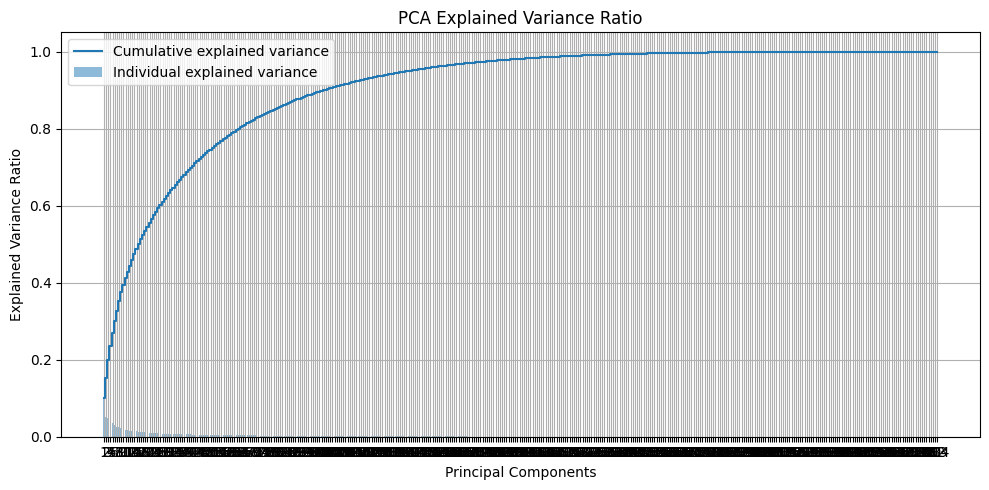

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA()
pca.fit(text_embeddings)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.title('PCA Explained Variance Ratio')
plt.grid()
plt.tight_layout()
plt.show()

In [58]:
# Find the number of principal components for at least x% variance
n_var_50 = np.where(cumulative_explained_variance >= 0.50)[0][0] + 1
n_var_60 = np.where(cumulative_explained_variance >= 0.60)[0][0] + 1
n_var_70 = np.where(cumulative_explained_variance >= 0.70)[0][0] + 1
n_var_80 = np.where(cumulative_explained_variance >= 0.80)[0][0] + 1
n_var_90 = np.where(cumulative_explained_variance >= 0.90)[0][0] + 1

print(f"50%:{n_var_50}; 60%:{n_var_60}; 70%:{n_var_70}; 80%:{n_var_80}; 90%:{n_var_90}")

50%:17; 60%:27; 70%:42; 80%:64; 90%:103


### Main BERTopic tuning run (PCA + HDBSCAN)

In [79]:
# Set up Range of n_components (parameter of PCA)
n_components_rng = range(10, 110, 10)

results = [["n_components", "total_clusters", "total_outliers", "min_cluster_size", "max_cluster_size", "avg_cluster_size", "sil_ex", "sil_in", "cal_ex", 
            "cal_in", "div_score", "c_v_score", "u_mass_score", "uci_score", "npmi_score"]]


# Loop for all possible n_components
for component in tqdm(n_components_rng):

    topic_model = BERTopic(
    
        # Pipeline models
        embedding_model=None,
        umap_model=get_pca(n_components=component), # Dimension Reduction method
        hdbscan_model=get_hdbscan(min_cluster_size=2, min_samples=None), # main Clustering algorithm
        vectorizer_model=get_Vectorizer(ngram_range=(1, 2), stop_words=stop_words_cust),
        representation_model=None,
    
        # Hyperparameters
        top_n_words=20,
        verbose = False
    )
    
    # Train model
    topics, probs = topic_model.fit_transform(docs, text_embeddings)

    # Retrieve meta data
    counter = topic_model.topic_sizes_.copy()
    total_clusters = max(topics) + 1
    try:
        total_outliers = counter.pop(-1)
    except:
        total_outliers = 0
    min_cluster_size = min(counter.values())
    max_cluster_size = max(counter.values())
    avg_cluster_size = sum(counter.values())/total_clusters

    # Extract the Text Embeddingsand Labels for exclude/include outliers
    indices = [index for index, topic in enumerate(topics) if topic != -1]
    X = text_embeddings[np.array(indices)]
    labels = [topic for index, topic in enumerate(topics) if topic != -1]
    
    indices_ = [index for index, topic in enumerate(topics)]
    X_ = text_embeddings[np.array(indices_)]
    labels_ = [topic for index, topic in enumerate(topics)]
    
    # Calculate silhouette and CH score
    sil_ex = silhouette_score(X, labels)
    ch_ex = calinski_harabasz_score(X, labels)
    sil_in = silhouette_score(X_, labels_)
    ch_in = calinski_harabasz_score(X_, labels_)

    # Compute Topic Diversity score by OCTIS
    bertopic_topics = [[vals[0] for vals in topic_model.get_topic(i)[:10]] for i in range(len(set(topics)) - 1)]
    output_tm = {"topics": bertopic_topics}
    topic_diversity = TopicDiversity(topk=10)
    div_score = topic_diversity.score(output_tm)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in docs]
    #tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]
    
    # Compute Topic Coherence Scores by Gensim
    c_v = CoherenceModel(topics=topic_words, topn=10,
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    u_mass = CoherenceModel(topics=topic_words, topn=10,
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='u_mass')
    uci = CoherenceModel(topics=topic_words, topn=10,
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_uci')
    npmi = CoherenceModel(topics=topic_words, topn=10,
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_npmi')
    c_v_score = c_v.get_coherence()
    u_mass_score = u_mass.get_coherence()
    uci_score = uci.get_coherence()
    npmi_score = npmi.get_coherence()

    result = [component, total_clusters, total_outliers, min_cluster_size, max_cluster_size, avg_cluster_size, 
              sil_ex, sil_in, ch_ex, ch_in, div_score, c_v_score, u_mass_score, uci_score, npmi_score]
    results.append(result)

  0%|          | 0/10 [00:00<?, ?it/s]2023-07-21 08:25:56,317 - BERTopic - Reduced dimensionality
2023-07-21 08:25:56,353 - BERTopic - Clustered reduced embeddings
 10%|█         | 1/10 [00:44<06:37, 44.19s/it]2023-07-21 08:26:40,512 - BERTopic - Reduced dimensionality
2023-07-21 08:26:40,552 - BERTopic - Clustered reduced embeddings
 20%|██        | 2/10 [01:35<06:25, 48.15s/it]2023-07-21 08:27:31,440 - BERTopic - Reduced dimensionality
2023-07-21 08:27:31,498 - BERTopic - Clustered reduced embeddings
 30%|███       | 3/10 [02:21<05:32, 47.46s/it]2023-07-21 08:28:18,063 - BERTopic - Reduced dimensionality
2023-07-21 08:28:18,122 - BERTopic - Clustered reduced embeddings
 40%|████      | 4/10 [03:05<04:34, 45.82s/it]2023-07-21 08:29:01,388 - BERTopic - Reduced dimensionality
2023-07-21 08:29:01,459 - BERTopic - Clustered reduced embeddings
 50%|█████     | 5/10 [03:49<03:46, 45.22s/it]2023-07-21 08:29:45,546 - BERTopic - Reduced dimensionality
2023-07-21 08:29:45,621 - BERTopic - Clust

Output Results of tuning run (PCA + HDBSCAN)

In [80]:
file_path_output = 'TuningOutputs/PCA_HDBSCAN_whole_full.csv'

# Open the file for writing
with open(file_path_output, mode='a', newline='', encoding='utf-8') as file:
    # Create a CSV writer
    csv_writer = csv.writer(file)
    
    # Write the data to the CSV file
    csv_writer.writerows(results)

(For reference only) Illustration of BERTopic built-in functions

In [82]:
topic_model = BERTopic(

    # Pipeline models
    embedding_model=None,
    umap_model=get_pca(n_components=80),
    hdbscan_model=get_hdbscan(min_cluster_size=2, min_samples=None),
    vectorizer_model=get_Vectorizer(ngram_range=(1, 2), stop_words=stop_words_cust),
    representation_model=None,

    # Hyperparameters
    top_n_words=20,
    verbose = False
)

# Train model
topics, probs = topic_model.fit_transform(docs, text_embeddings)

2023-07-21 08:39:06,338 - BERTopic - Reduced dimensionality
2023-07-21 08:39:06,414 - BERTopic - Clustered reduced embeddings


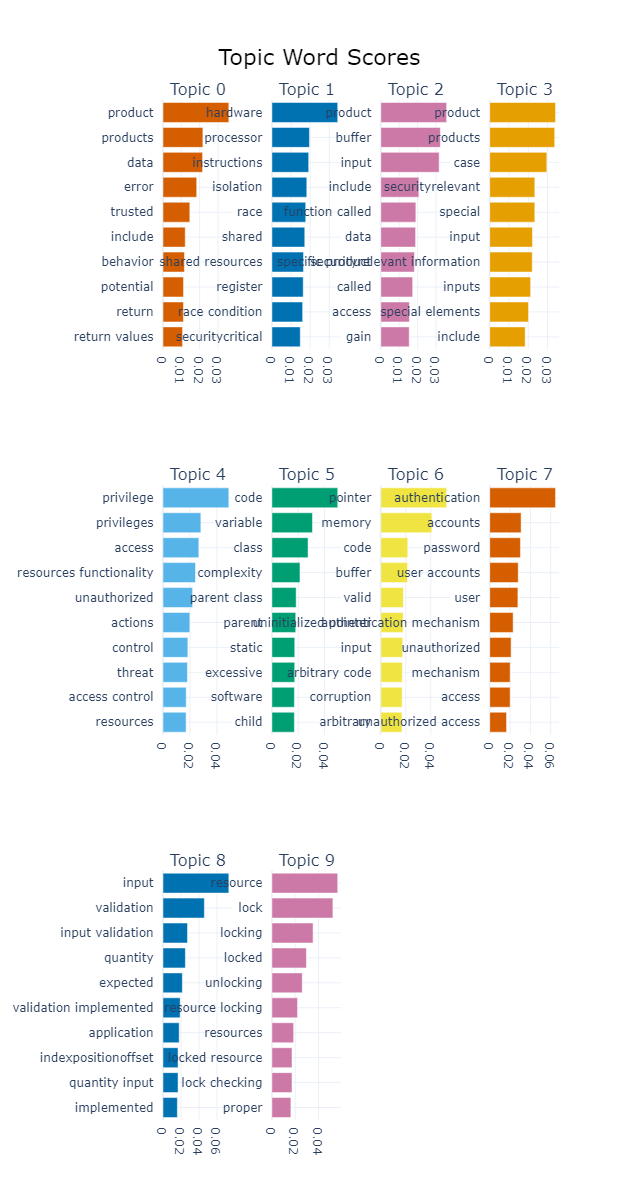

In [86]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10, height=400, width=250)

In [87]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,312,-1_access_data_include_unauthorized,"[access, data, include, unauthorized, informat...",[The vulnerability in CWE 497 is the product's...
1,0,16,0_product_products_data_error,"[product, products, data, error, trusted, incl...",[The vulnerability in CWE 346 is the lack of p...
2,1,12,1_hardware_processor_instructions_isolation,"[hardware, processor, instructions, isolation,...",[The vulnerability in CWE 1313 is the presence...
3,2,11,2_product_buffer_input_include,"[product, buffer, input, include, function cal...",[The vulnerability in this CWE is the use of a...
4,3,9,3_product_products_case_securityrelevant,"[product, products, case, securityrelevant, sp...",[The vulnerability is the product's inability ...
5,4,9,4_privilege_privileges_access_resources functi...,"[privilege, privileges, access, resources func...",[The vulnerability in CWE 270 is the improper ...
6,5,8,5_code_variable_class_complexity,"[code, variable, class, complexity, parent cla...",[The vulnerability in CWE 1080 is the presence...
7,6,7,6_pointer_memory_code_buffer,"[pointer, memory, code, buffer, valid, uniniti...",[The vulnerability in CWE 825 is the dereferen...
8,7,6,7_authentication_accounts_password_user accounts,"[authentication, accounts, password, user acco...",[The vulnerability in this case is the weak me...
9,8,6,8_input_validation_input validation_quantity,"[input, validation, input validation, quantity...",[The vulnerability in CWE 1284 is the lack of ...


### Tuning for K-mean K by fixing PCA (n=80) (PCA + K-Means)

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_embeddings = PCA(n_components=80, random_state=0).fit_transform(text_embeddings)

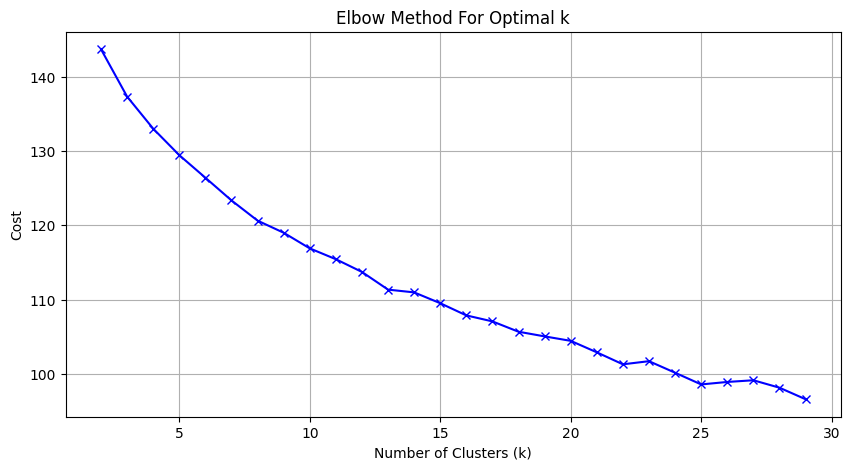

In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow method for reference only, obsolete in the paper
# Run KMeans for a range of k values and collect the cost values
cost = []
sil_scores = []
K_range = range(2, 30, 1)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_embeddings)
    cost.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(umap_embeddings, labels))

# Plot the cost against the number of clusters
plt.figure(figsize=(10, 5))
plt.plot(K_range, cost, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

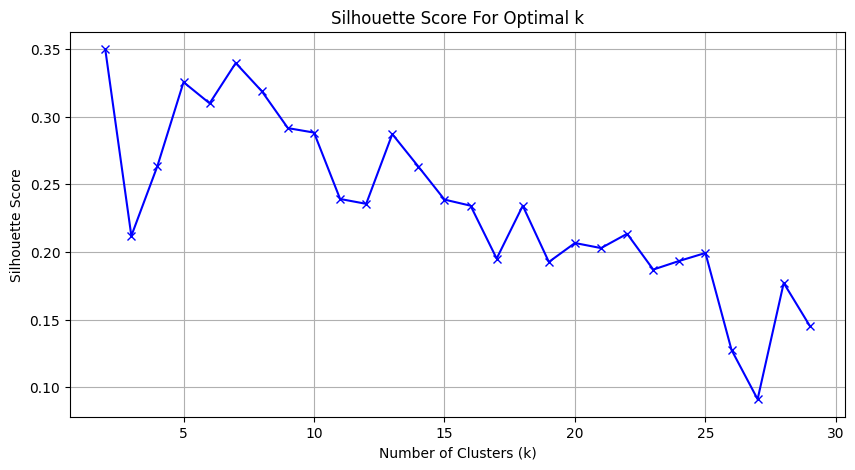

In [90]:
# Silhouette method to determine K
# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(10, 5))
plt.plot(K_range, sil_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.grid()
plt.show()

### Tuning for PCA for fixing K-means (K=7)

In [94]:
# Set up Range of n_components (PCA parameter)
n_components_rng = range(10, 110, 10)
n_clusters=7

results = [["n_components", "total_clusters", "total_outliers", "min_cluster_size", "max_cluster_size", "avg_cluster_size", "sil_ex", "sil_in", "cal_ex", 
            "cal_in", "div_score", "c_v_score", "u_mass_score", "uci_score", "npmi_score"]]

for component in tqdm(n_components_rng):

    topic_model = BERTopic(
    
        # Pipeline models
        embedding_model=None,
        umap_model=get_pca(n_components=component), # Dimension Reduction method
        hdbscan_model=get_kmeans(n_clusters=n_clusters), # main Clustering algorithm
        vectorizer_model=get_Vectorizer(ngram_range=(1, 2), stop_words=stop_words_cust),
        representation_model=None,
    
        # Hyperparameters
        top_n_words=20,
        verbose = False
    )
    
    # Train model
    topics, probs = topic_model.fit_transform(docs, text_embeddings)

    # Retrieve meta data
    counter = topic_model.topic_sizes_.copy()
    total_clusters = max(topics) + 1
    try:
        total_outliers = counter.pop(-1)
    except:
        total_outliers = 0
    min_cluster_size = min(counter.values())
    max_cluster_size = max(counter.values())
    avg_cluster_size = sum(counter.values())/total_clusters

    # Extract the Text Embeddingsand Labels for exclude/include outliers
    indices = [index for index, topic in enumerate(topics) if topic != -1]
    X = text_embeddings[np.array(indices)]
    labels = [topic for index, topic in enumerate(topics) if topic != -1]
    
    indices_ = [index for index, topic in enumerate(topics)]
    X_ = text_embeddings[np.array(indices_)]
    labels_ = [topic for index, topic in enumerate(topics)]
    
    # Calculate silhouette and CH score
    sil_ex = silhouette_score(X, labels)
    ch_ex = calinski_harabasz_score(X, labels)
    sil_in = silhouette_score(X_, labels_)
    ch_in = calinski_harabasz_score(X_, labels_)

    # Compute Topic Diversity score by OCTIS
    bertopic_topics = [[vals[0] for vals in topic_model.get_topic(i)[:10]] for i in range(len(set(topics)) - 1)]
    output_tm = {"topics": bertopic_topics}
    topic_diversity = TopicDiversity(topk=10)
    div_score = topic_diversity.score(output_tm)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in docs]
    #tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]
    
    # Compute Topic Coherence Scores by Gensim
    c_v = CoherenceModel(topics=topic_words, topn=10,
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    u_mass = CoherenceModel(topics=topic_words, topn=10,
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='u_mass')
    uci = CoherenceModel(topics=topic_words, topn=10,
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_uci')
    npmi = CoherenceModel(topics=topic_words, topn=10,
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_npmi')
    c_v_score = c_v.get_coherence()
    u_mass_score = u_mass.get_coherence()
    uci_score = uci.get_coherence()
    npmi_score = npmi.get_coherence()

    result = [n_clusters, component, total_clusters, total_outliers, min_cluster_size, max_cluster_size, avg_cluster_size, 
              sil_ex, sil_in, ch_ex, ch_in, div_score, c_v_score, u_mass_score, uci_score, npmi_score]
    results.append(result)

  0%|          | 0/10 [00:00<?, ?it/s]2023-07-21 12:51:42,220 - BERTopic - Reduced dimensionality
2023-07-21 12:51:42,229 - BERTopic - Clustered reduced embeddings
 10%|█         | 1/10 [00:43<06:30, 43.42s/it]2023-07-21 12:52:25,638 - BERTopic - Reduced dimensionality
2023-07-21 12:52:25,646 - BERTopic - Clustered reduced embeddings
 20%|██        | 2/10 [01:23<05:31, 41.39s/it]2023-07-21 12:53:05,605 - BERTopic - Reduced dimensionality
2023-07-21 12:53:05,614 - BERTopic - Clustered reduced embeddings
 30%|███       | 3/10 [02:03<04:46, 40.93s/it]2023-07-21 12:53:45,983 - BERTopic - Reduced dimensionality
2023-07-21 12:53:45,991 - BERTopic - Clustered reduced embeddings
 40%|████      | 4/10 [02:42<03:59, 39.87s/it]2023-07-21 12:54:24,229 - BERTopic - Reduced dimensionality
2023-07-21 12:54:24,237 - BERTopic - Clustered reduced embeddings
 50%|█████     | 5/10 [03:20<03:17, 39.45s/it]2023-07-21 12:55:02,942 - BERTopic - Reduced dimensionality
2023-07-21 12:55:02,951 - BERTopic - Clust

Output Results of tuning run (PCA + K-means)

In [95]:
file_path_output = 'TuningOutputs/PCA_K-Means_whole_full.csv'

# Open the file for writing
with open(file_path_output, mode='a', newline='', encoding='utf-8') as file:
    # Create a CSV writer
    csv_writer = csv.writer(file)
    
    # Write the data to the CSV file
    csv_writer.writerows(results)

For reference only, visualize_barchart function of BERTopic

In [91]:
topic_model = BERTopic(

    # Pipeline models
    embedding_model=None,
    umap_model=get_pca(n_components=80),
    hdbscan_model=get_kmeans(n_clusters=7, random_state=0),
    vectorizer_model=get_Vectorizer(ngram_range=(1, 2), stop_words=stop_words_cust),
    representation_model=None,

    # Hyperparameters
    top_n_words=20,
    verbose = False
)

# Train model
topics, probs = topic_model.fit_transform(docs, text_embeddings)

2023-07-21 08:51:19,757 - BERTopic - Reduced dimensionality
2023-07-21 08:51:19,767 - BERTopic - Clustered reduced embeddings


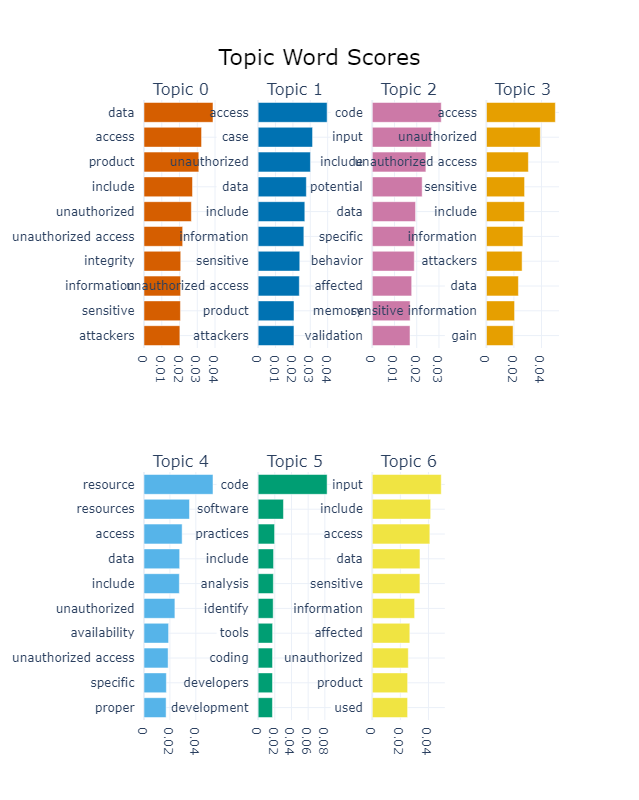

In [92]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10, height=400, width=250)